# Python Foundation - Capstone Project

## Exploratory Data Analysis on ‘Dog Training’ YouTube Channel

## Problem Statement:

- Thailand is a country with less dog training knowledge in comparison to Europe or even our neighbor Singapore
- One of the main reason is the lack in available educational resources which has stalled developments of both the training skills of trainers and the knowledge of the people
- Which allows many ‘poor’, ‘abusive’ and ‘unethical’ dog trainers/breeders to easily take advantage of their customers – from selling ineffective (even counter-productive) courses to breeding and selling of unhealthy dogs

## Goal:

- Identify key action points to build and expand my own educational dog training YouTube channel by analyzing insights from dog training channels

## Target:

- +100 subscribers & +100 views per video

## Social Impact:

"More educated customers" => "Less unethical trainers/breeders"

## Hypothesis

- Which content relates to the viewers?

- Effects of good title writing?

- What’s the best video duration?

- How many times posts per month?

- Is it better to post on weekdays or weekends?

## Project Pipeline

### 1. Knowledge curation
- Research on dog training channels
- Select appropriate dog training channels for good starting datasets
- Understanding how to use YouTube API

### 2. Data Scraping
- Use YouTube Data API v3
- Extract channel stats, vidoe id's in each channel, video details for each video ids, and comments details for each video ids

### 3. Data Preprocessing
- Ensure data are in the right formatting - e.g. datetime must be datetime
- Investigate null values and select the best method to deal with each of them
- Feature engineering other columns - e.g. day of the week, video duration in minutes, channel tiers, age of the channel, tags count, title length, etc.

### 4. Exploratory Data Analysis
- Subscribers range to separate channel into tiers for comparison
- Correlation of features
- Investigate the hypotheses based on each channel tier for comparison
- wordclouds to investigate popular title, topics, and comments

### 5. Conclusion
- Identify key action points to grow "PointyFloppy" channel

# Importing the required modules, and setting some global parameters

In [1]:
#data manipulation
import pandas as pd
import numpy as np
from dateutil import parser
import isodate

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#NLP lib
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
from wordcloud import WordCloud

In [2]:
#day ordering
day_order = 'Monday Tuesday Wednesday Thursday Friday Saturday Sunday'.split()

In [3]:
#chosen palette
use_palette = 'magma'

In [4]:
#chosen range and ordering of channel visualization
channel_range = ['high','medium','low']

# Reading and Data Preparation/Feature Engineering for channel data

In [5]:
#read scraped data
ch_df = pd.read_csv('channel_df.csv', index_col=[0])

#### Check datatypes

In [6]:
ch_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   channel_title       30 non-null     object
 1   channel_desc        25 non-null     object
 2   channel_loc         23 non-null     object
 3   channel_pub_date    30 non-null     object
 4   channel_view        30 non-null     int64 
 5   channel_sub         30 non-null     int64 
 6   channel_video       30 non-null     int64 
 7   channel_playlistId  30 non-null     object
dtypes: int64(3), object(5)
memory usage: 2.1+ KB


- channel_pub_date : should be datetime
- channel_view, channel_sub, channel_video : should be numeric

In [7]:
#change published date to the correct datatype
ch_df['channel_pub_date'] =  ch_df['channel_pub_date'].apply(lambda x: parser.parse(x))

#feature engineer published year
ch_df['channel_pub_year'] = ch_df['channel_pub_date'].apply(lambda x: x.strftime("%Y"))

In [8]:
#selecting columns to convert to numeric
cols_to_numeric = ['channel_view','channel_sub','channel_video','channel_pub_year']

In [9]:
#convert datatypes to numeric - coerce = invalid passing as NaN
ch_df[cols_to_numeric] = ch_df[cols_to_numeric].apply(pd.to_numeric,errors='coerce')

In [10]:
#feature engineering view per video channel
ch_df['view_per_video'] = ch_df['channel_view'] / ch_df['channel_video']

We can separate our analysis by channel type based on numbers of subscribers

__Premium tier (sub > 100,000)__ 


__Medium tier (10,000 < sub <= 100,000)__

__Low tier (sub <= 10,000)__


In [11]:
#sorting channel tier
def channel_tier(subs):
    #return channel tier from no. of subscribers
    """
    subs = int, number of subscribers
    """
    if subs > 100000:
        return "high"
    elif subs > 10000:
        return "medium"
    else:
        return "low"

In [12]:
#apply function to sort channel tier
ch_df['channel_tier'] = ch_df['channel_sub'].apply(channel_tier)

#### Check missing data

In [13]:
ch_df.isnull().mean()[ch_df.isnull().mean() != 0]*100

channel_desc    16.666667
channel_loc     23.333333
dtype: float64

In [14]:
#fill missing description
ch_df['channel_desc'].fillna('No Description',inplace=True)

In [15]:
#fill missing location
ch_df['channel_loc'].fillna('No Location',inplace=True)

#### Final check

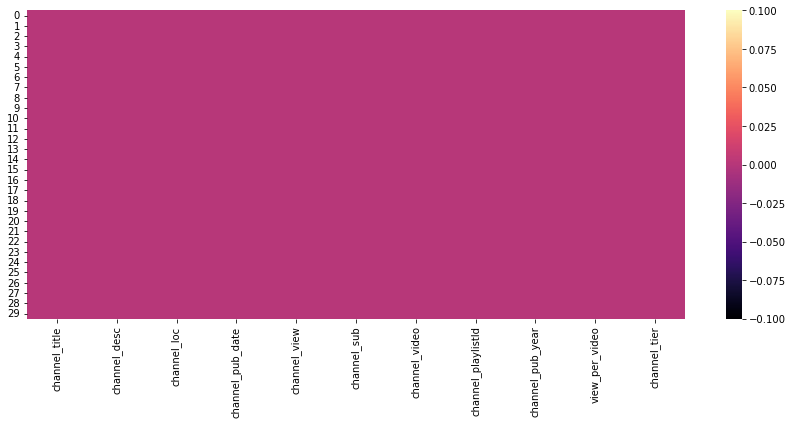

In [16]:
#showing that data is complete and in correct format
plt.figure(figsize=(12,6))
sns.heatmap(ch_df.isnull(),cmap='magma')
plt.tight_layout()
plt.savefig('./Figures/channel_nonull.jpg')

In [17]:
ch_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype                  
---  ------              --------------  -----                  
 0   channel_title       30 non-null     object                 
 1   channel_desc        30 non-null     object                 
 2   channel_loc         30 non-null     object                 
 3   channel_pub_date    30 non-null     datetime64[ns, tzutc()]
 4   channel_view        30 non-null     int64                  
 5   channel_sub         30 non-null     int64                  
 6   channel_video       30 non-null     int64                  
 7   channel_playlistId  30 non-null     object                 
 8   channel_pub_year    30 non-null     int64                  
 9   view_per_video      30 non-null     float64                
 10  channel_tier        30 non-null     object                 
dtypes: datetime64[ns, tzutc()](1), float64(1), int6

No missing values and correct datatypes

## Data Validation for fairness of datasets

In [18]:
ch_df['channel_tier'].value_counts()

low       11
high      10
medium     9
Name: channel_tier, dtype: int64

Similar number of channels from each channel tier

In [19]:
ch_df.groupby('channel_tier').sum()['channel_video']

channel_tier
high      9254
low       2171
medium    2431
Name: channel_video, dtype: int64

Significantly higher videos from high tier, let's investigate outliers

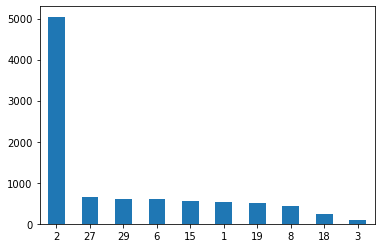

In [20]:
ch_df[ch_df['channel_tier']=='high'].sort_values('channel_video',ascending=False)['channel_video'].plot(kind='bar')
plt.xticks(rotation=0);

In [21]:
ch_df.loc[2] #this channel is an outlier, having way more videos than other channels

channel_title         Peter Caine Dog Training 
channel_desc                     No Description
channel_loc                                  US
channel_pub_date      2010-12-24 22:00:49+00:00
channel_view                           36287638
channel_sub                              185000
channel_video                              5045
channel_playlistId     UUGBhmRCsK-hdGyKUP-K02zw
channel_pub_year                           2010
view_per_video                      7192.792468
channel_tier                               high
Name: 2, dtype: object

Investigating this channel shows that he posts everything from daily life to YouTube short videos, and including this would increase inaccuracies. We will drop this channel.

In [22]:
ch_df = ch_df.drop([2])

In [23]:
ch_df.groupby('channel_tier').sum()['channel_video']

channel_tier
high      4209
low       2171
medium    2431
Name: channel_video, dtype: int64

High tier has twice the number of videos, this is sensible because larger channels tend to post more videos

Now we have a fair datasets with similar channel from each tiers, and sensible number of videos from each tiers

# Reading and Data Preparation/Feature Engineering for video Data Frame

In [24]:
#read csv
video_df = pd.read_csv('video_df.csv')

#### Check datatypes

In [25]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13861 entries, 0 to 13860
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   video_id       13861 non-null  object 
 1   channelTitle   13861 non-null  object 
 2   title          13861 non-null  object 
 3   description    13223 non-null  object 
 4   tags           11126 non-null  object 
 5   publishedAt    13861 non-null  object 
 6   duration       13861 non-null  object 
 7   definition     13861 non-null  object 
 8   caption        13861 non-null  bool   
 9   viewCount      13861 non-null  int64  
 10  likeCount      13843 non-null  float64
 11  favoriteCount  13861 non-null  int64  
 12  commentCount   13373 non-null  float64
dtypes: bool(1), float64(2), int64(2), object(8)
memory usage: 1.3+ MB


- not datatypes but let's rename column 'channelTitle' to 'channel_title'

- tags needs to be a list of strings
- publishedAt needs to be datetime
- duration needs to be seconds or minutes
- viewCount likeCount favoriteCount commentCount is int from API

In [26]:
#applying datetime string parser
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x))

#feature engineering day / month / year of publishing
video_df['publishedDay'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))
video_df['publishedMonth'] = video_df['publishedAt'].apply(lambda x: x.strftime("%m"))
video_df['publishedYear'] = video_df['publishedAt'].apply(lambda x: x.strftime("%Y"))

In [27]:
#converting datatypes to numeric
num_cols = ['viewCount', 'likeCount','commentCount','publishedMonth','publishedYear']
video_df[num_cols] = video_df[num_cols].apply(pd.to_numeric, errors='coerce')

In [28]:
#applying parser
video_df['duration_sec'] = video_df['duration'].apply(lambda x : isodate.parse_duration(x))

#feature enginineering seconds and minutes (rounded)
video_df['duration_sec'] = video_df['duration_sec'].astype('timedelta64[s]')
video_df['duration_min'] = video_df['duration_sec'].apply(lambda x : round(x/60))

In [29]:
#input list brackets into empty tags columns
video_df['tags'].fillna("[]",inplace=True)

In [30]:
#converting tags to list
video_df['tags_list'] = video_df['tags'].apply(lambda x : x.strip("[]").replace("'","").split(', '))

#feature engineering tags count
video_df['tags_count'] = video_df['tags_list'].apply(lambda x : len(x))

In [31]:
#feature engineering like and comments ratio
video_df['likeRatio'] = video_df['likeCount'] / video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount'] / video_df['viewCount'] * 1000

In [32]:
#feature engineering title length
video_df['title_length'] = video_df['title'].apply(lambda x: len(x))

#### Check for missing data

In [33]:
round(video_df.isnull().mean(),4)[video_df.isnull().mean() != 0]*100

description     4.60
likeCount       0.13
commentCount    3.52
likeRatio       0.17
commentRatio    3.57
dtype: float64

Missing descriptions are just videos without description so we can fill with "No Description"


Missing like and comments are from videos that disabled likes or comments (we can drop these)

In [34]:
#fill missing description
video_df['description'].fillna('No Description',inplace=True)

Drop missing data from columns that takes up < 5%

In [35]:
video_df.dropna(subset='likeCount',axis=0,inplace=True)
video_df.dropna(subset='commentCount',axis=0,inplace=True)
video_df.dropna(subset='commentRatio',axis=0,inplace=True)

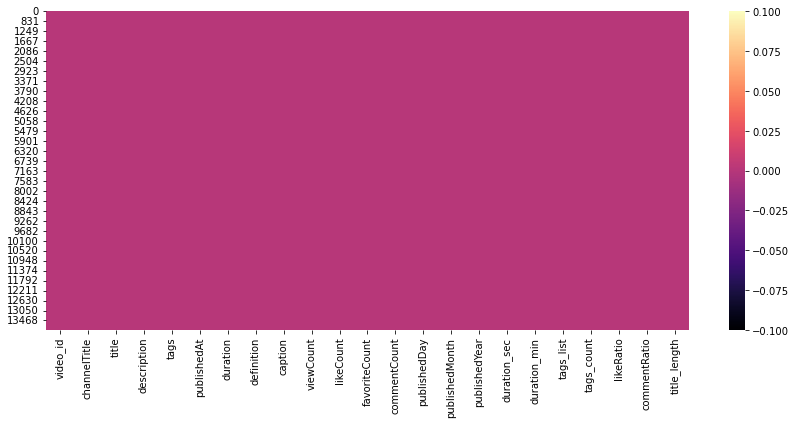

In [36]:
#showing that the data is complete and in correct format
plt.figure(figsize=(12,6))
sns.heatmap(video_df.isnull(),cmap='magma')
plt.tight_layout()
plt.savefig('./Figures/video_nonull.jpg');

In [37]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13349 entries, 0 to 13860
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype                  
---  ------          --------------  -----                  
 0   video_id        13349 non-null  object                 
 1   channelTitle    13349 non-null  object                 
 2   title           13349 non-null  object                 
 3   description     13349 non-null  object                 
 4   tags            13349 non-null  object                 
 5   publishedAt     13349 non-null  datetime64[ns, tzutc()]
 6   duration        13349 non-null  object                 
 7   definition      13349 non-null  object                 
 8   caption         13349 non-null  bool                   
 9   viewCount       13349 non-null  int64                  
 10  likeCount       13349 non-null  float64                
 11  favoriteCount   13349 non-null  int64                  
 12  commentCount    13349 non-null  

In [38]:
#check what column 'favorite count is'
video_df['favoriteCount'].value_counts()

0    13349
Name: favoriteCount, dtype: int64

Whole column has no favorite, so we can just drop this column as well

In [39]:
video_df.drop('favoriteCount',axis=1,inplace=True)

Creating a list of channel titles in each channel tier to map with video

In [40]:
low_ch_title = list(ch_df[ch_df['channel_tier']=='low']['channel_title'])
medium_ch_title = list(ch_df[ch_df['channel_tier']=='medium']['channel_title'])
high_ch_title = list(ch_df[ch_df['channel_tier']=='high']['channel_title'])

Create a function to map video to channel tier

In [41]:
def video_tier(channelTitle):
    #map video with channel tier of the same channel title
    """
    channelTitle = str, name of channel that posted certain video
    """
    if channelTitle in high_ch_title:
        return 'high'
    elif channelTitle in medium_ch_title:
        return 'medium'
    else:
        return 'low'

Applying the function to video_df to create channel_tier column

In [42]:
video_df['channel_tier'] = video_df['channelTitle'].apply(video_tier)

In [43]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13349 entries, 0 to 13860
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype                  
---  ------          --------------  -----                  
 0   video_id        13349 non-null  object                 
 1   channelTitle    13349 non-null  object                 
 2   title           13349 non-null  object                 
 3   description     13349 non-null  object                 
 4   tags            13349 non-null  object                 
 5   publishedAt     13349 non-null  datetime64[ns, tzutc()]
 6   duration        13349 non-null  object                 
 7   definition      13349 non-null  object                 
 8   caption         13349 non-null  bool                   
 9   viewCount       13349 non-null  int64                  
 10  likeCount       13349 non-null  float64                
 11  commentCount    13349 non-null  float64                
 12  publishedDay    13349 non-null  

# EDA : Channel Datasets

In [44]:
#Have a quick look at the dataframe
ch_df.sort_values(by='channel_video',ascending=False).head(5)

channel_title  \
16  Royvon Dog Training and Hotels   
27             McCann Dog Training   
29                     Larry Krohn   
6          Dog Training by Kikopup   
28               Saro Dog Training   

                                         channel_desc channel_loc  \
16  Offering quality and professional pet services...          GB   
27  At McCann Professional Dog Trainers, we train ...          CA   
29  Professional dog trainer Larry Krohn, owner an...          US   
6   Professional dog training videos created by wo...          US   
28  Gain control over your dog using a simple rewa...          CA   

            channel_pub_date  channel_view  channel_sub  channel_video  \
16 2014-04-11 14:48:31+00:00       3294420        12700            738   
27 2010-03-05 01:47:56+00:00      70345702      1020000            658   
29 2009-04-05 14:00:31+00:00      13014012       132000            596   
6  2007-04-06 05:11:22+00:00      41588347       359000            595   
28 2013-07-29 22:56:42+00:00       4372398        60800            558   

          channel_playlistId  channel_pub_year  view_per_video channel_tier  
16  UULL9mXGZIRLcSpZiLBxRT0Q              2014     4463.983740       medium  
27  UU5QwYlOxcT1higtcJVGzCCg              2010   106908.361702         high  
29  UUortXxJdZYbHCrOa3nddr6g              2009    21835.590604         high  
6   UU-qnqaajTk6bfs3UZuue6IQ              2007    69896.381513         high  
28  UUqiW2BB9Aed5ITI__nTLPFQ              2013     7835.838710       medium

We have excluded the outlier channel

## Investigate the range of subscribers in each channel

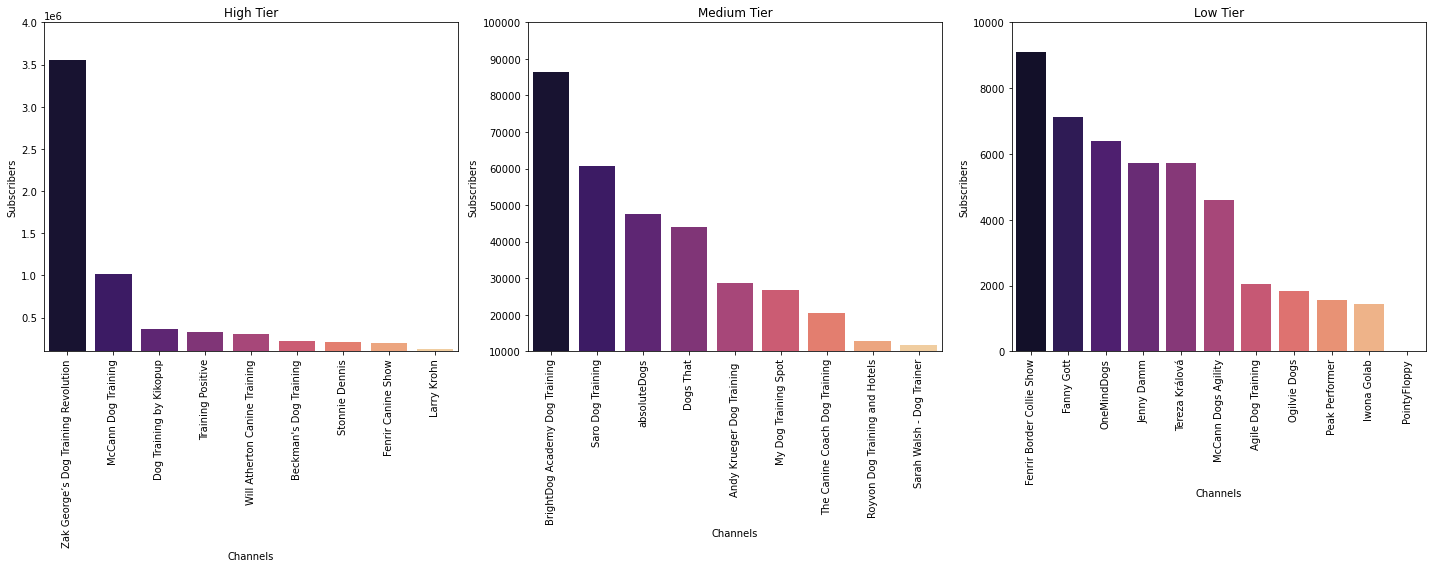

In [45]:
fig, axes = plt.subplots(1, 3,figsize=(20,8))

plot_range = [[100000,4000000],[10000,100000],[0,10000]]

for i in range(3):
    sns.barplot(ax=axes[i], x='channel_title', y='channel_sub',data=ch_df[ch_df['channel_tier']==channel_range[i]].sort_values(by='channel_sub',ascending=False),palette=use_palette)
    axes[i].set_xticklabels(ch_df[ch_df['channel_tier']==channel_range[i]].sort_values(by='channel_sub',ascending=False)['channel_title'],rotation = 90)
    axes[i].set_ylim(plot_range[i])
    axes[i].set_title(f'{channel_range[i].capitalize()} Tier')
    axes[i].set_xlabel('Channels')
    axes[i].set_ylabel('Subscribers')

plt.tight_layout()
plt.savefig('./Figures/channels_sub.jpg')

## Investigate number of videos in each channel

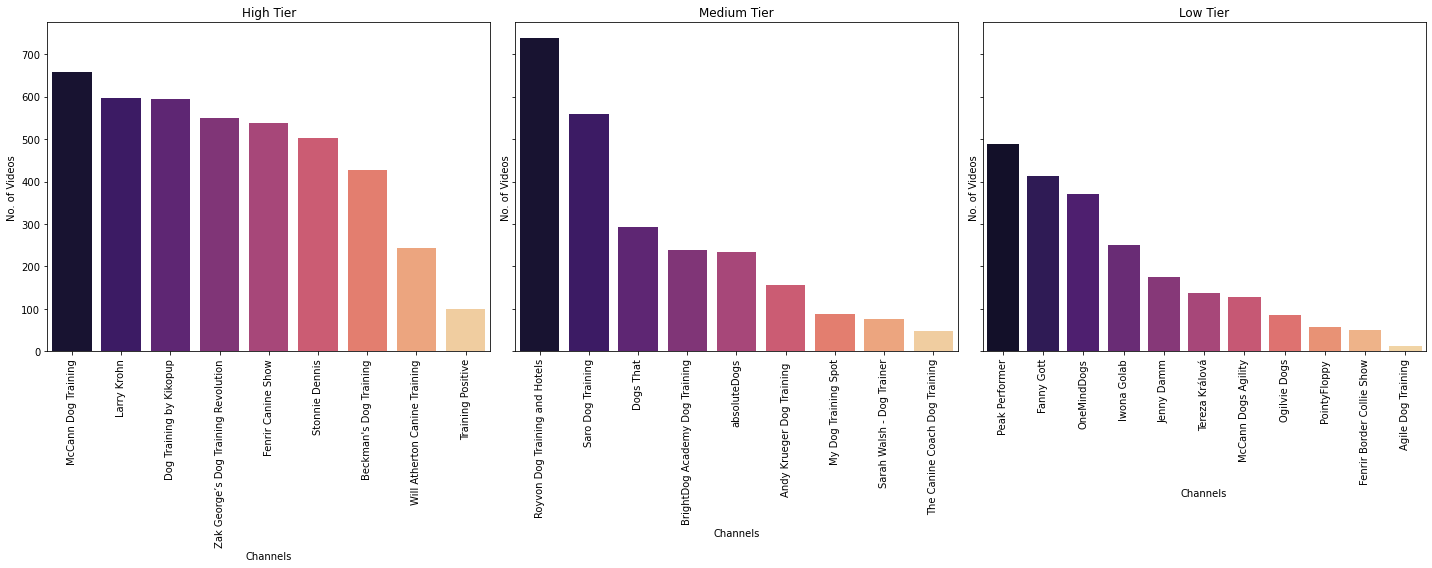

In [46]:
fig, axes = plt.subplots(1, 3,figsize=(20,8),sharey=True)

for i in range(3):
    sns.barplot(ax=axes[i], x='channel_title', y='channel_video',data=ch_df[ch_df['channel_tier']==channel_range[i]].sort_values(by='channel_video',ascending=False),palette=use_palette)
    axes[i].set_xticklabels(ch_df[ch_df['channel_tier']==channel_range[i]].sort_values(by='channel_video',ascending=False)['channel_title'],rotation = 90)
    axes[i].set_title(f'{channel_range[i].capitalize()} Tier')
    axes[i].set_xlabel('Channels')
    axes[i].set_ylabel('No. of Videos')

plt.tight_layout()
plt.savefig('./Figures/channels_vid.jpg')

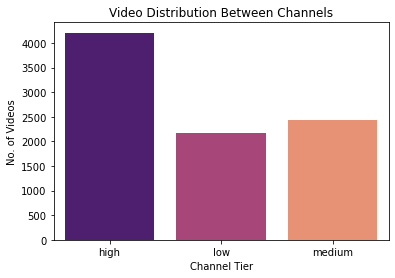

In [47]:
#sum of videos in each channel
num_video = ch_df.groupby(by='channel_tier').sum()['channel_video']
ax = sns.barplot(x=num_video.index,y=num_video,palette=use_palette)
ax.set_xlabel('Channel Tier')
ax.set_ylabel('No. of Videos')
ax.set_title('Video Distribution Between Channels');

More videos in high section but that's expected

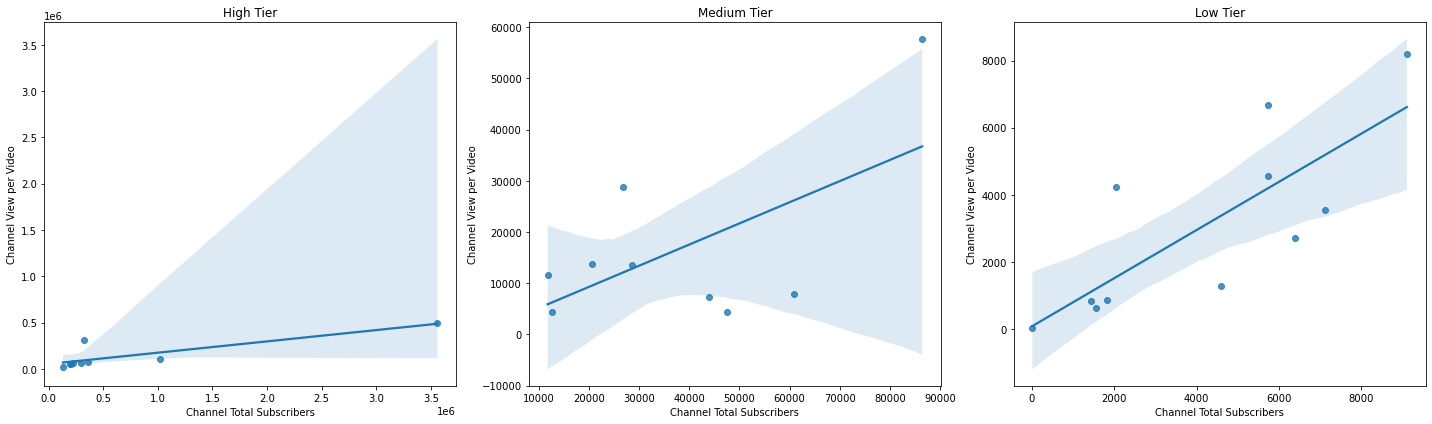

In [48]:
#excluding the top two outliers - we will investigate the channel sub vs channel views
fig, axes = plt.subplots(1, 3,figsize=(20,6))

for i in range(3):
    sns.regplot(ax=axes[i], x='channel_sub', y='view_per_video',data=ch_df[ch_df['channel_tier']==channel_range[i]])
    axes[i].set_title(f'{channel_range[i].capitalize()} Tier')
    axes[i].set_xlabel('Channel Total Subscribers')
    axes[i].set_ylabel('Channel View per Video')

plt.tight_layout()
plt.savefig('./Figures/channel_sub_vs_view.jpg')

#### Checking age range of channels

In [49]:
high = ch_df.groupby('channel_tier').sum()['channel_pub_year'][0] / ch_df.groupby('channel_tier').count()['channel_title'][0]
medium = ch_df.groupby('channel_tier').sum()['channel_pub_year'][2] / ch_df.groupby('channel_tier').count()['channel_title'][2]
low = ch_df.groupby('channel_tier').sum()['channel_pub_year'][1] / ch_df.groupby('channel_tier').count()['channel_title'][1]

print(f"Average age of high tier channels : {round(2022 - high,0)}")
print(f"Average age of medium tier channels : {round(2022 - medium,0)}")
print(f"Average age of low tier channels : {round(2022 - low,0)}")

Average age of high tier channels : 11.0
Average age of medium tier channels : 6.0
Average age of low tier channels : 11.0


We have quite a range of channel age, this should help diversify the datasets for fairness

# EDA : Video Datasets

Double checking the datasets

In [50]:
video_df.head(5)

video_id         channelTitle  \
0  6ZV2Qk7zwME  McCann Dogs Agility   
1  HV1S-hIkyh0  McCann Dogs Agility   
2  sHPVpX-p-ck  McCann Dogs Agility   
3  XVCTAUQkdDY  McCann Dogs Agility   
4  ExdMGCn7XOg  McCann Dogs Agility   

                                               title  \
0  Kayl McCann & Bee-Line - UKI Ontario Fall Cup ...   
1  Ep7: Part 1: A Conversation with Jaakko Suoknu...   
2  Run or Stop? That is the question…..  Here Is ...   
3  Ep6: Training & Competing with Multiple Dogs -...   
4  Agility Coursework - May 2021/ Coach Kayl McCa...   

                                         description  \
0  I’m a little late with posting my Fall Cup rec...   
1  We are so pumped for this 2-part conversation ...   
2  Running or Stop Contacts…..well, I’d say, if y...   
3  If you play Agility, you know it's an amazingl...   
4  This weeks training sessions with Bee-Line 🐝\n...   

                                                tags  \
0  ['Agility', 'Dog Agility', 'Bee-Line', 'Kayl M...   
1  ['kayl', 'mccann', 'dog', 'agility', 'dog agil...   
2                                                 []   
3  ['kayl', 'mccann', 'dog', 'agility', 'dog agil...   
4                                                 []   

                publishedAt   duration definition  caption  viewCount  ...  \
0 2021-10-30 22:19:00+00:00    PT5M14S         hd    False       1648  ...   
1 2021-06-26 04:00:23+00:00  PT1H3M21S         hd    False        986  ...   
2 2021-06-10 13:07:33+00:00    PT1M15S         hd    False        874  ...   
3 2021-06-04 12:00:26+00:00    PT36M1S         hd    False        384  ...   
4 2021-05-23 05:02:56+00:00    PT1M49S         hd    False        802  ...   

   publishedMonth  publishedYear duration_sec  duration_min  \
0              10           2021        314.0             5   
1               6           2021       3801.0            63   
2               6           2021         75.0             1   
3               6           2021       2161.0            36   
4               5           2021        109.0             2   

                                           tags_list  tags_count  likeRatio  \
0  [Agility, Dog Agility, Bee-Line, Kayl McCann, ...           6  20.024272   
1  [kayl, mccann, dog, agility, dog agility train...          20  18.255578   
2                                                 []           1  18.306636   
3  [kayl, mccann, dog, agility, dog agility train...          15  41.666667   
4                                                 []           1  29.925187   

  commentRatio  title_length  channel_tier  
0     1.820388            61           low  
1     0.000000            71           low  
2     2.288330            55           low  
3     7.812500            66           low  
4     1.246883            78           low  

[5 rows x 23 columns]

Remove peter caine videos, it is identified as an outlier

In [51]:
video_df = video_df[video_df['channelTitle'] != "Peter Caine Dog Training "]

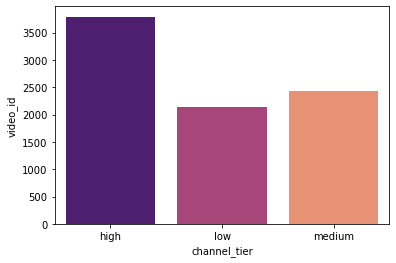

In [52]:
#verify peter caine has been removed from no. of videos
sns.barplot(x=video_df.groupby('channel_tier').count()['video_id'].index,y=video_df.groupby('channel_tier').count()['video_id'],palette=use_palette);

Matches the number of videos from cleaned channel datasets, we're good to go

## Check correlation of each features

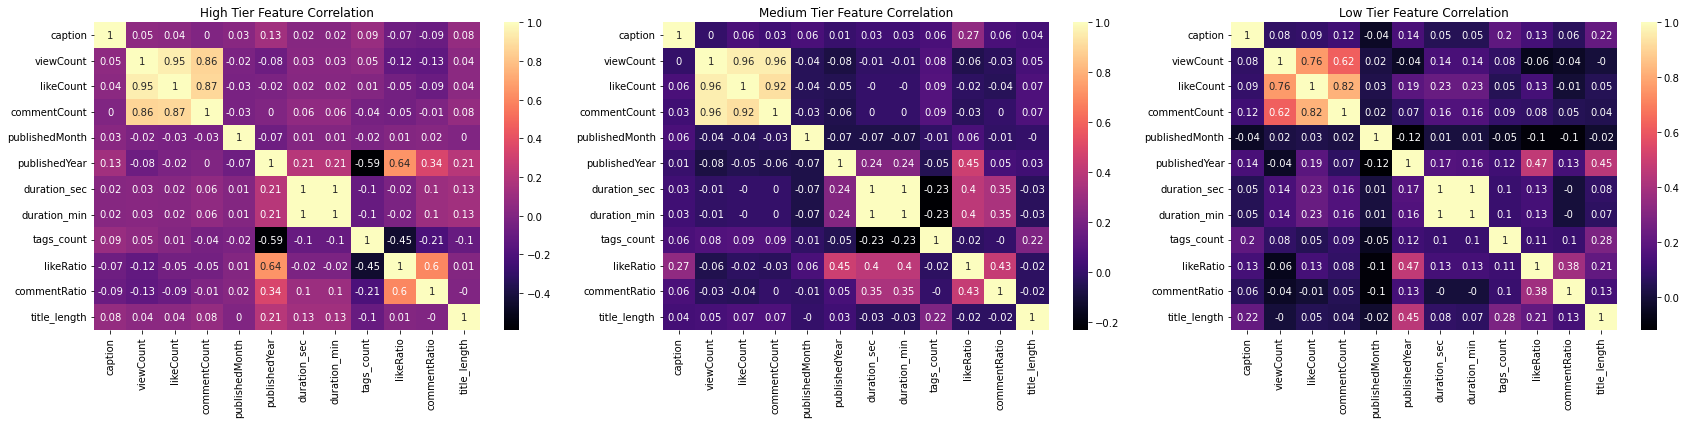

In [53]:
fig, axes = plt.subplots(1, 3,figsize=(24,6))

for i in range(3):
    ax = sns.heatmap(ax=axes[i], data=video_df[video_df['channel_tier']==channel_range[i]].corr().round(2),annot=True, cmap=use_palette)
    ax.set_title(f'{channel_range[i].capitalize()} Tier Feature Correlation')

plt.tight_layout()
plt.savefig('./Figures/channel_tier_correlation.jpg')

## Check correlation of view vs like/comment

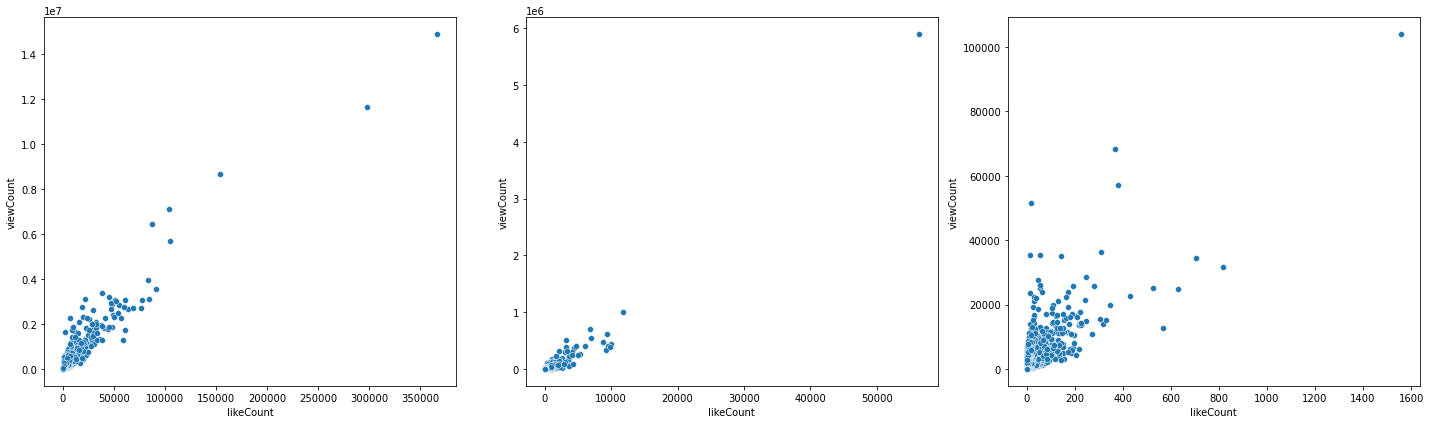

In [54]:
fig, axes = plt.subplots(1, 3,figsize=(20,6))

for i in range(3):
    sns.scatterplot(ax=axes[i], x=video_df[video_df['channel_tier']==channel_range[i]]['likeCount'],y=video_df[video_df['channel_tier']==channel_range[i]]['viewCount'])

plt.tight_layout()
plt.savefig('./Figures/viewlike_correlation.jpg')

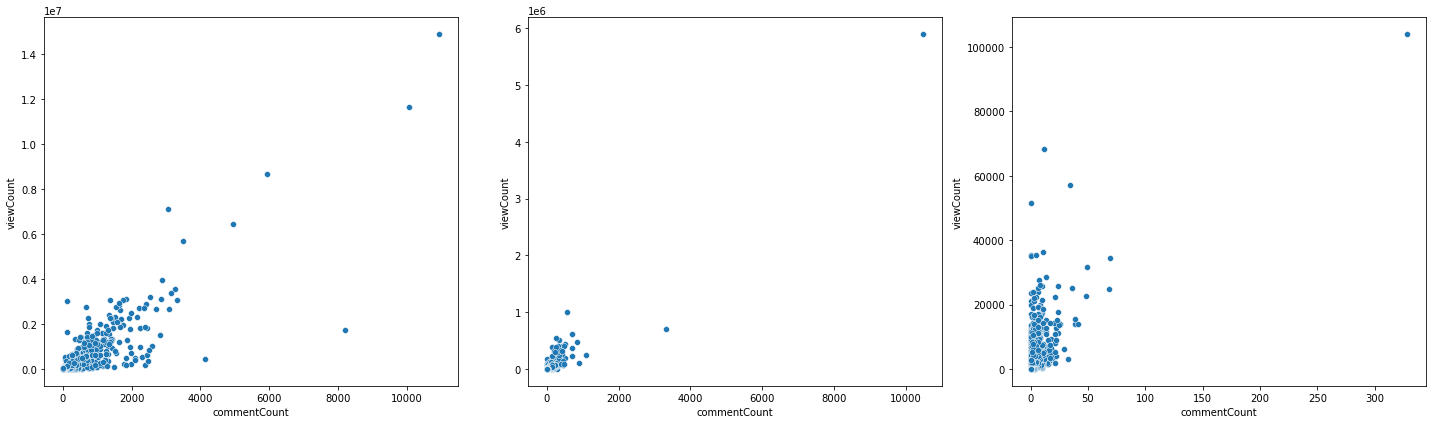

In [55]:
fig, axes = plt.subplots(1, 3,figsize=(20,6))

for i in range(3):
    sns.scatterplot(ax=axes[i], x=video_df[video_df['channel_tier']==channel_range[i]]['commentCount'],y=video_df[video_df['channel_tier']==channel_range[i]]['viewCount'])

plt.tight_layout()
plt.savefig('./Figures/viewcomment_correlation.jpg')

More correlation with like, but view and like always comes together because only those who view will like

Adjust plot by plotting with ratio i.e. / 1000

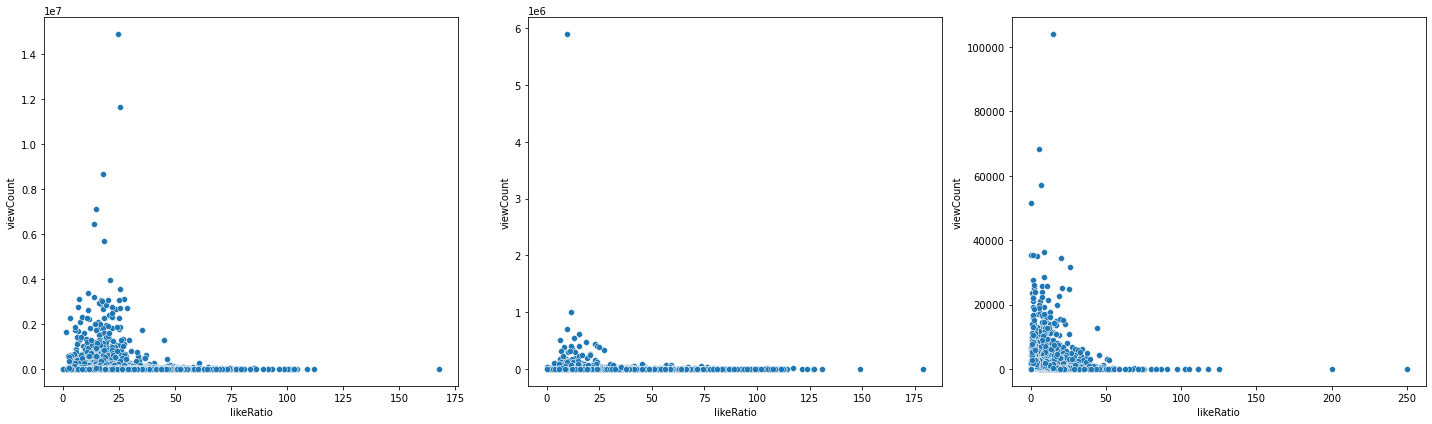

In [56]:
fig, axes = plt.subplots(1, 3,figsize=(20,6))

for i in range(3):
    sns.scatterplot(ax=axes[i], x=video_df[video_df['channel_tier']==channel_range[i]]['likeRatio'],y=video_df[video_df['channel_tier']==channel_range[i]]['viewCount'])

plt.tight_layout()
plt.savefig('./Figures/viewlikeratio_correlation.jpg')

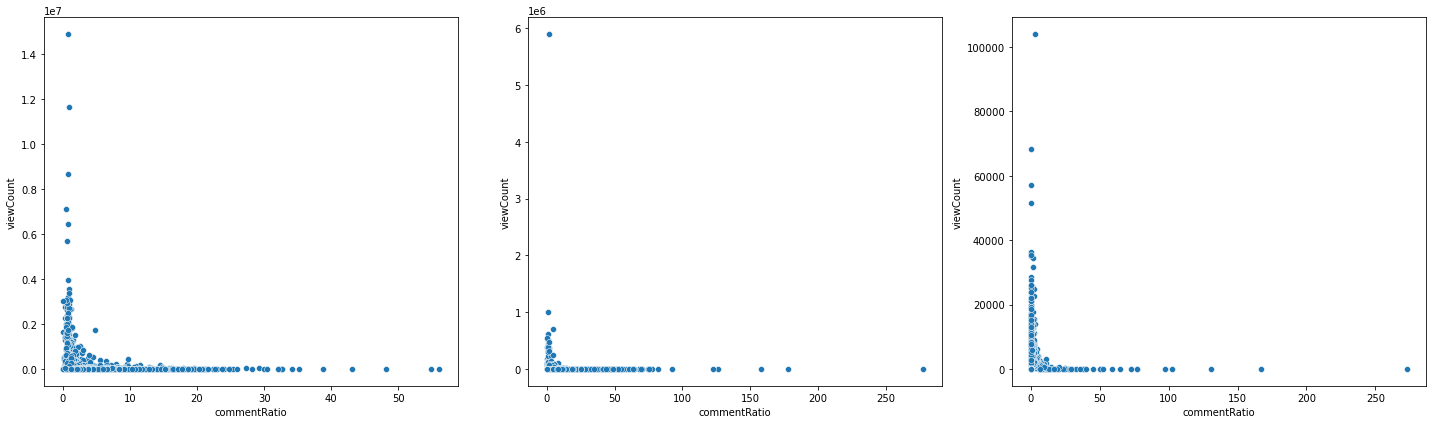

In [57]:
fig, axes = plt.subplots(1, 3,figsize=(20,6))

for i in range(3):
    sns.scatterplot(ax=axes[i], x=video_df[video_df['channel_tier']==channel_range[i]]['commentRatio'],y=video_df[video_df['channel_tier']==channel_range[i]]['viewCount'])

plt.tight_layout()
plt.savefig('./Figures/viewcommentratio_correlation.jpg')

Some trends left but nothing worth taking from this correlation

## Check average tags per video per channel and by tier

In [58]:
video_tag_df = pd.DataFrame(video_df.groupby(by='channelTitle').mean()['tags_count'])
video_tag_df = video_tag_df.merge(ch_df[['channel_title','channel_tier']],left_on='channelTitle',right_on='channel_title',how='left')

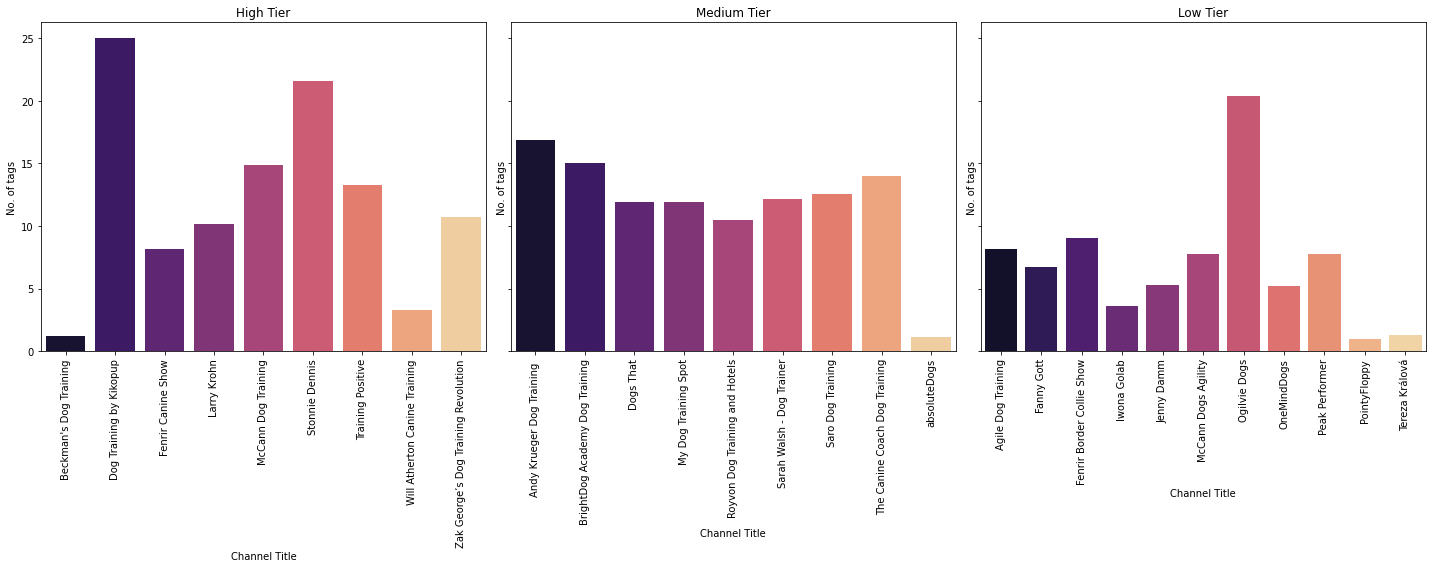

In [59]:
fig, axes = plt.subplots(1, 3,figsize=(20,8),sharey=True)

for i in range(3):
    sns.barplot(ax=axes[i], x='channel_title', y='tags_count',data=video_tag_df[video_tag_df['channel_tier']==channel_range[i]],palette=use_palette)
    axes[i].set_xticklabels(video_tag_df[video_tag_df['channel_tier']==channel_range[i]]['channel_title'],rotation = 90)
    axes[i].set_title(f'{channel_range[i].capitalize()} Tier')
    axes[i].set_xlabel('Channel Title')
    axes[i].set_ylabel('No. of tags')

plt.tight_layout()
plt.savefig('./Figures/tags_per_channel.jpg')

## Investigating relationships between tags and view counts

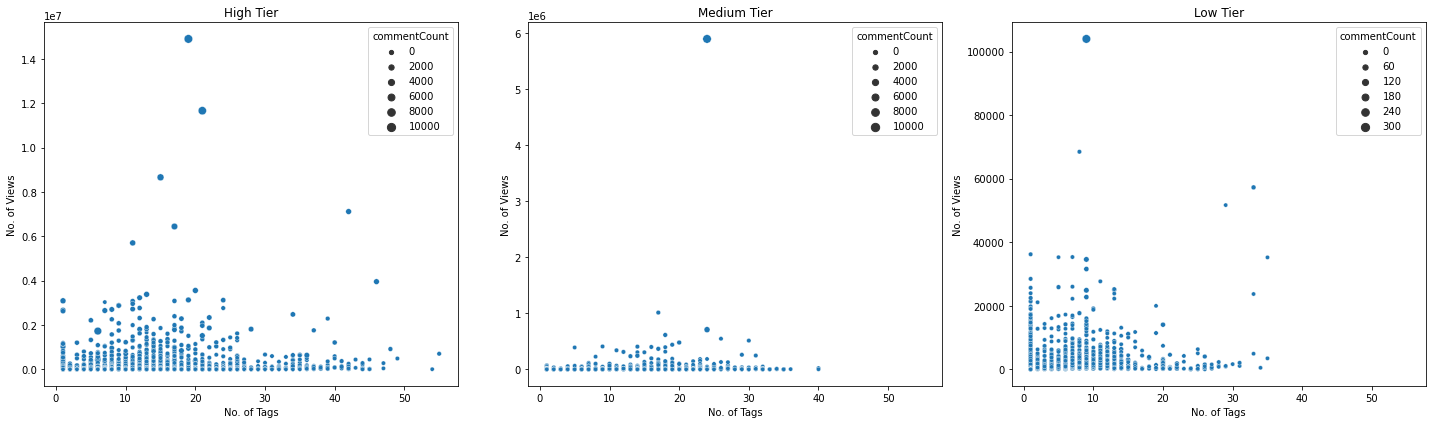

In [60]:
fig, axes = plt.subplots(1, 3,figsize=(20,6),sharex=True)

for i in range(3):
    sns.scatterplot(ax=axes[i],x='tags_count', y='viewCount', data=video_df[video_df['channel_tier']==channel_range[i]],size='commentCount')
    axes[i].set_title(f'{channel_range[i].capitalize()} Tier')
    axes[i].set_ylabel('No. of Views')
    axes[i].set_xlabel('No. of Tags')

plt.tight_layout()
plt.savefig('./Figures/tags_view.jpg')

## Investigate relationship between title length and view counts

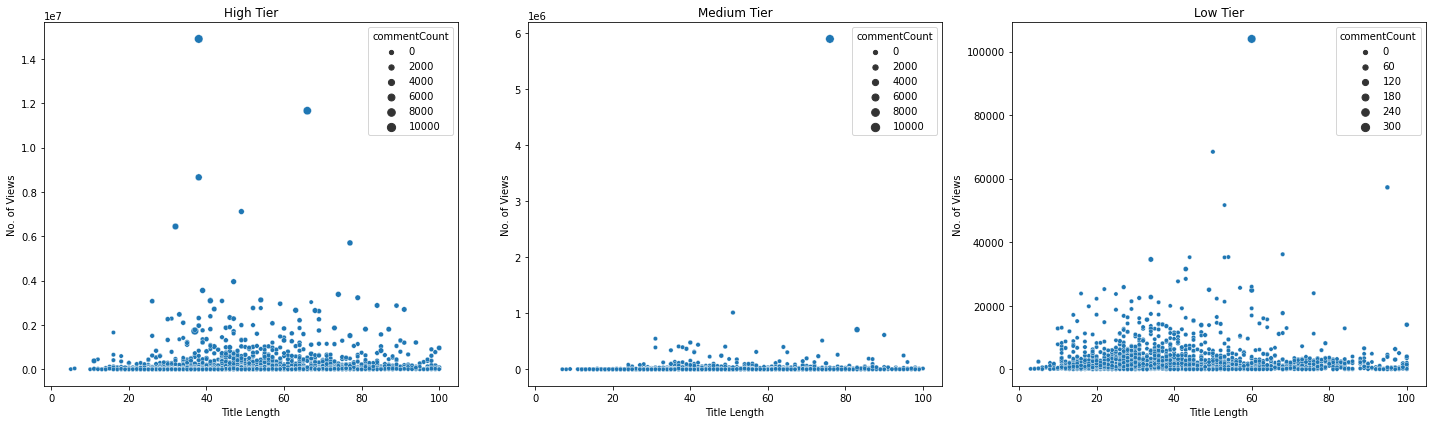

In [61]:
fig, axes = plt.subplots(1, 3,figsize=(20,6),sharex=True)

for i in range(3):
    sns.scatterplot(ax=axes[i],x='title_length',y='viewCount',data=video_df[video_df['channel_tier']==channel_range[i]],size='commentCount')
    axes[i].set_title(f'{channel_range[i].capitalize()} Tier')
    axes[i].set_ylabel('No. of Views')
    axes[i].set_xlabel('Title Length')

plt.tight_layout()
plt.savefig('./Figures/title_length_view.jpg')

## Video duration correlation with view count

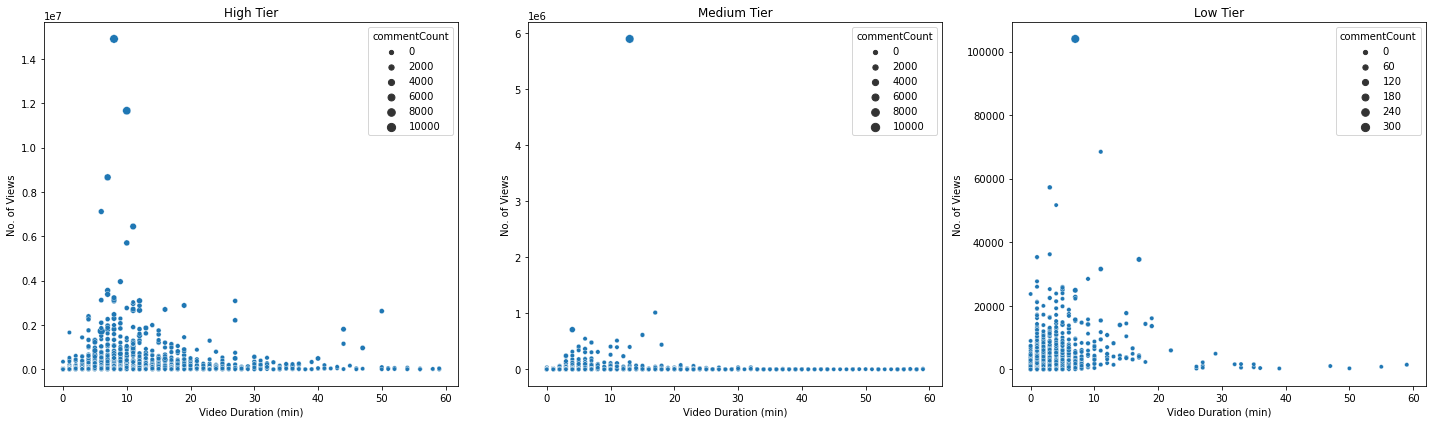

In [62]:
fig, axes = plt.subplots(1, 3,figsize=(20,6),sharex=True)

for i in range(3):
    sns.scatterplot(ax=axes[i],x='duration_min',y='viewCount',data=video_df[(video_df['channel_tier']==channel_range[i]) & (video_df['duration_min'] < 60)],size='commentCount')
    axes[i].set_title(f'{channel_range[i].capitalize()} Tier')
    axes[i].set_xlabel('Video Duration (min)')
    axes[i].set_ylabel('No. of Views')

plt.tight_layout()
plt.savefig('./Figures/duration_view_scatter.jpg')

#limited to 60 min to exclude livestream

## Distribution of video duration

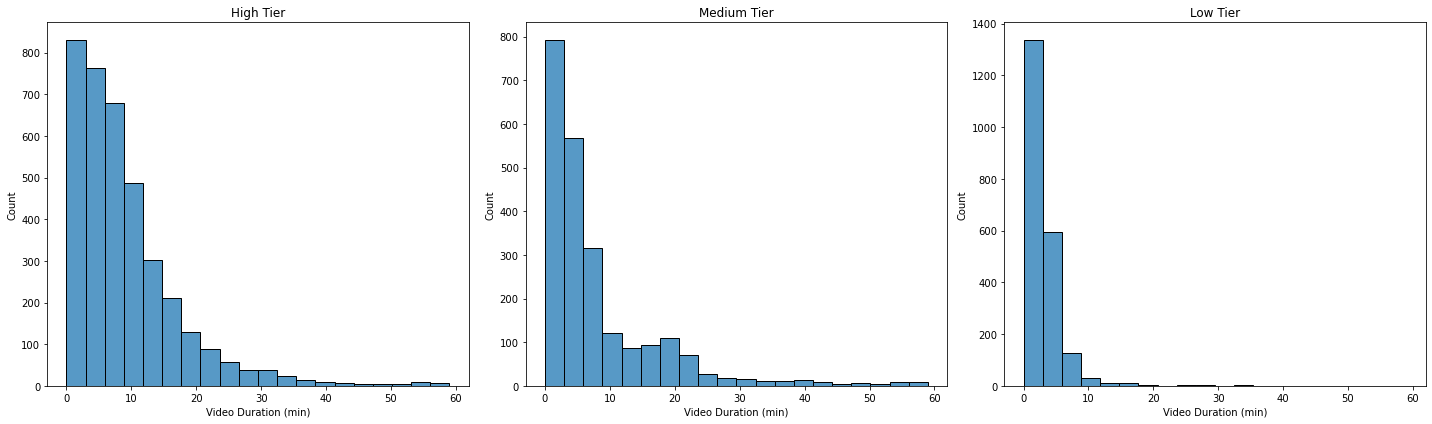

In [63]:
fig, axes = plt.subplots(1, 3,figsize=(20,6),sharex=True)

for i in range(3):
    sns.histplot(ax=axes[i],x='duration_min', bins=20, data=video_df[(video_df['channel_tier']==channel_range[i]) & (video_df['duration_min'] < 60)],palette=use_palette)
    axes[i].set_title(f'{channel_range[i].capitalize()} Tier')
    axes[i].set_xlabel('Video Duration (min)')

plt.tight_layout()
plt.savefig('./Figures/duration_distribution.jpg')

#limited to 60 min to exclude livestream

## Exploration of days of the week

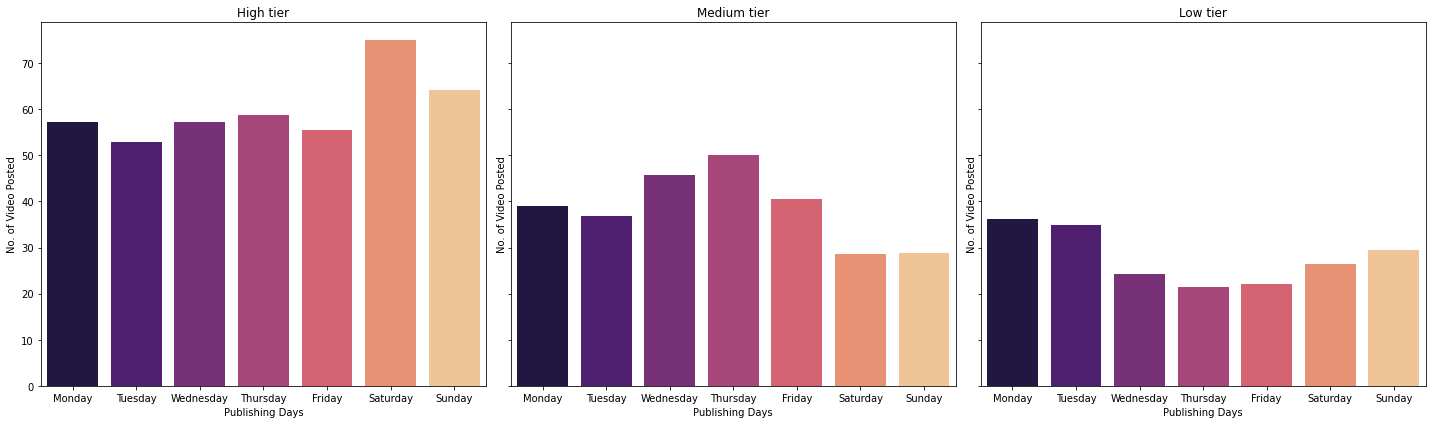

In [64]:
#calculate the average no. of videos per channel posted for each channel tier
high_posted_video = pd.DataFrame(video_df[video_df['channel_tier']=='high'].groupby('publishedDay').count()['video_id']/ch_df[ch_df['channel_tier']=='high']['channel_title'].count())
medium_posted_video = pd.DataFrame(video_df[video_df['channel_tier']=='medium'].groupby('publishedDay').count()['video_id']/ch_df[ch_df['channel_tier']=='medium']['channel_title'].count())
low_posted_video = pd.DataFrame(video_df[video_df['channel_tier']=='low'].groupby('publishedDay').count()['video_id']/ch_df[ch_df['channel_tier']=='low']['channel_title'].count())

fig, axes = plt.subplots(1, 3,figsize=(20,6),sharey=True)

sns.barplot(ax=axes[0], x=high_posted_video.index, y='video_id', data=high_posted_video, order=day_order,palette=use_palette)
axes[0].set_title('High tier')
axes[0].set_ylabel('No. of Video Posted')
axes[0].set_xlabel('Publishing Days')

sns.barplot(ax=axes[1], x=medium_posted_video.index, y='video_id', data=medium_posted_video, order=day_order,palette=use_palette)
axes[1].set_title('Medium tier')
axes[1].set_ylabel('No. of Video Posted')
axes[1].set_xlabel('Publishing Days')

sns.barplot(ax=axes[2], x=low_posted_video.index, y='video_id', data=low_posted_video, order=day_order,palette=use_palette)
axes[2].set_title('Low tier')
axes[2].set_ylabel('No. of Video Posted')
axes[2].set_xlabel('Publishing Days')

plt.tight_layout()
plt.savefig('./Figures/day_post.jpg')

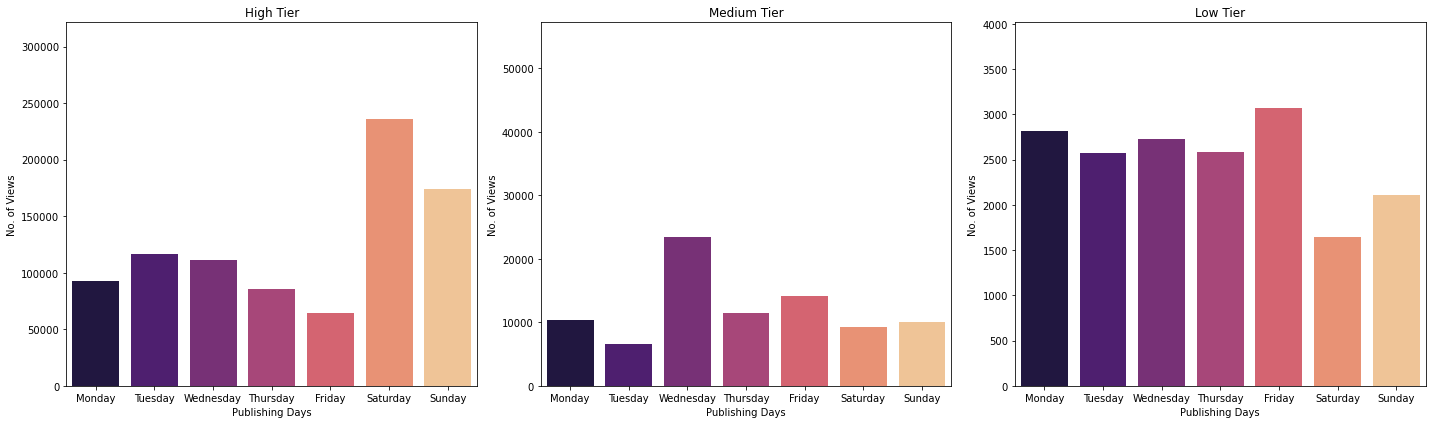

In [65]:
fig, axes = plt.subplots(1, 3,figsize=(20,6))

for i in range(3):
    sns.barplot(ax=axes[i], x='publishedDay', y='viewCount', data=video_df[video_df['channel_tier']==channel_range[i]],order=day_order,palette=use_palette,errwidth=0)
    axes[i].set_title(f'{channel_range[i].capitalize()} Tier')
    axes[i].set_ylabel('No. of Views')
    axes[i].set_xlabel('Publishing Days')

plt.tight_layout()
plt.savefig('./Figures/day_view.jpg')

Slightly higher video posted on weekends give much higher views on weekends suggest effectiveness

## Investigate effects of months to post video

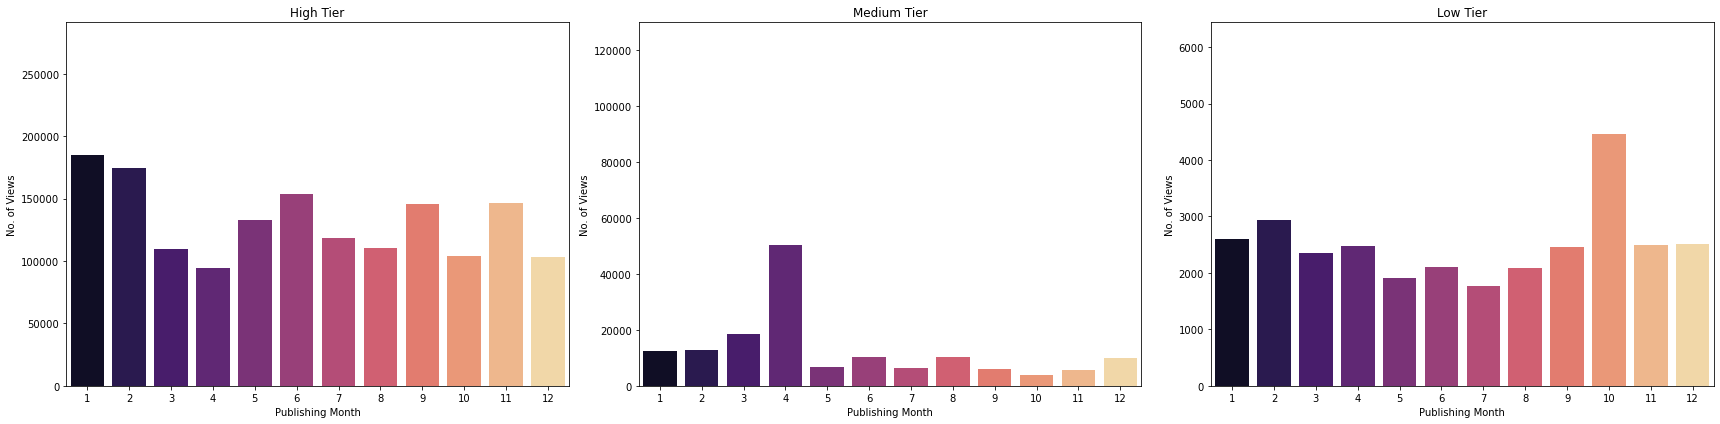

In [66]:
fig, axes = plt.subplots(1, 3,figsize=(24,6))

for i in range(3):
    sns.barplot(ax=axes[i], x='publishedMonth', y='viewCount', data=video_df[video_df['channel_tier']==channel_range[i]],palette=use_palette,errwidth=0)
    axes[i].set_title(f'{channel_range[i].capitalize()} Tier')
    axes[i].set_ylabel('No. of Views')
    axes[i].set_xlabel('Publishing Month')

plt.tight_layout()
plt.savefig('./Figures/month_view.jpg')

## Let's look at videos published per month in 2021

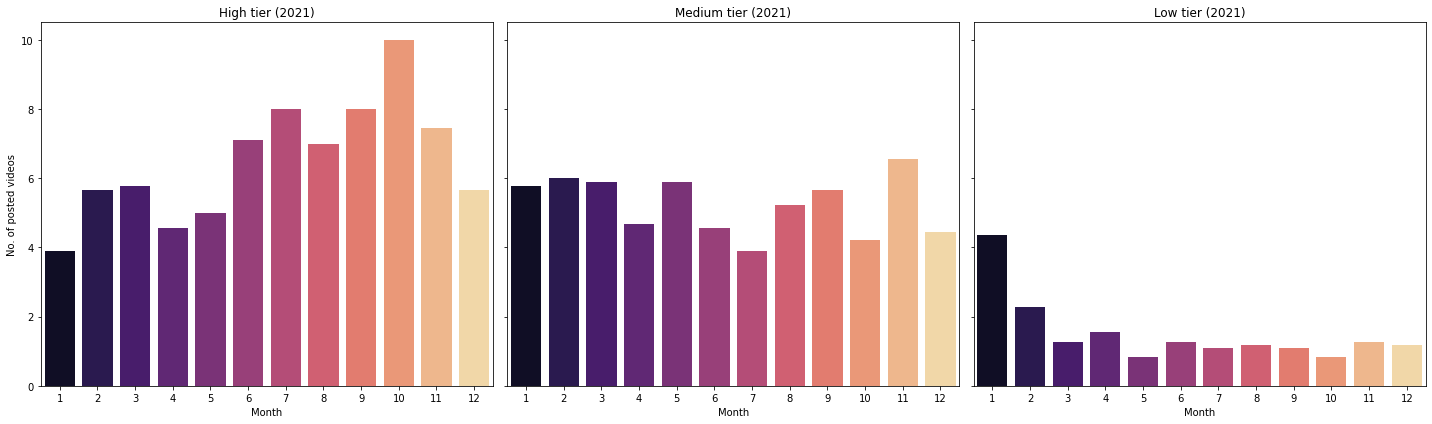

In [67]:
#check average posted videos per month
fig, axes = plt.subplots(1, 3,figsize=(20,6),sharey=True)

high_posted_video = pd.DataFrame(video_df[(video_df['channel_tier']=='high') & (video_df['publishedYear'] == 2021)].groupby('publishedMonth').count()['video_id']/ch_df[ch_df['channel_tier']=='high']['channel_title'].count())
medium_posted_video = pd.DataFrame(video_df[(video_df['channel_tier']=='medium') & (video_df['publishedYear'] == 2021)].groupby('publishedMonth').count()['video_id']/ch_df[ch_df['channel_tier']=='medium']['channel_title'].count())
low_posted_video = pd.DataFrame(video_df[(video_df['channel_tier']=='low') & (video_df['publishedYear'] == 2021)].groupby('publishedMonth').count()['video_id']/ch_df[ch_df['channel_tier']=='low']['channel_title'].count())

sns.barplot(ax=axes[0],x=high_posted_video.index,y='video_id',data=high_posted_video, palette=use_palette)
axes[0].set_title('High tier (2021)')
axes[0].set_ylabel('No. of posted videos')
axes[0].set_xlabel('Month')

sns.barplot(ax=axes[1],x=medium_posted_video.index,y='video_id',data=medium_posted_video, palette=use_palette)
axes[1].set_title('Medium tier (2021)')
axes[1].set_ylabel('')
axes[1].set_xlabel('Month')

sns.barplot(ax=axes[2],x=low_posted_video.index,y='video_id',data=low_posted_video, palette=use_palette)
axes[2].set_title('Low tier (2021)')
axes[2].set_ylabel('')
axes[2].set_xlabel('Month')

plt.tight_layout()
plt.savefig('./Figures/post_per_month.jpg')

This shows higher consistency and amount of videos posted per month by high and medium tier channels

## Investigate title, comments, and tags using wordcloud

In [68]:
#setting stop words to english
stop_words = set(stopwords.words('english'))

#creating empty dataframe to store titles
low_title = pd.DataFrame()
medium_title = pd.DataFrame()
high_title = pd.DataFrame()

#remove stopwords from titles and store to column 'title_no_stopwords'
low_title['title_no_stopwords'] = video_df[video_df['channel_tier']=='low']['title'].apply(lambda x : [item for item in x.split() if item not in stop_words])
medium_title['title_no_stopwords'] = video_df[video_df['channel_tier']=='medium']['title'].apply(lambda x : [item for item in x.split() if item not in stop_words])
high_title['title_no_stopwords'] = video_df[video_df['channel_tier']=='high']['title'].apply(lambda x : [item for item in x.split() if item not in stop_words])

In [69]:
#convert list of list to one list of title words
low_title_words = [a for b in low_title['title_no_stopwords'].tolist() for a in b] 
medium_title_words = [a for b in medium_title['title_no_stopwords'].tolist() for a in b] 
high_title_words = [a for b in high_title['title_no_stopwords'].tolist() for a in b]

In [70]:
#join list to one giant string of title words
low_title_words_str = ' '.join(low_title_words)
medium_title_words_str = ' '.join(medium_title_words)
high_title_words_str = ' '.join(high_title_words)

In [71]:
#define wordcloud function
def plot_cloud(wordcloud):
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off');

#define wordcloud features
low_wordcloud = WordCloud(width=500,
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(low_title_words_str)

medium_wordcloud = WordCloud(width=500, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(medium_title_words_str)

high_wordcloud = WordCloud(width=500, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(high_title_words_str)

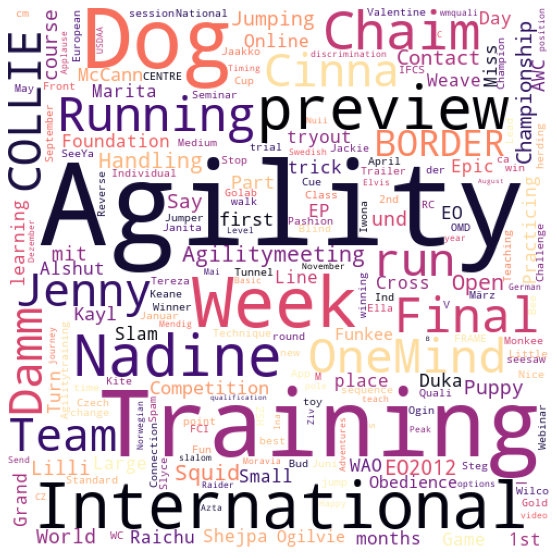

In [72]:
#plot wordcloud and save figure
plot_cloud(low_wordcloud)
plt.savefig('./Figures/lowtitlewordcloud.jpg')

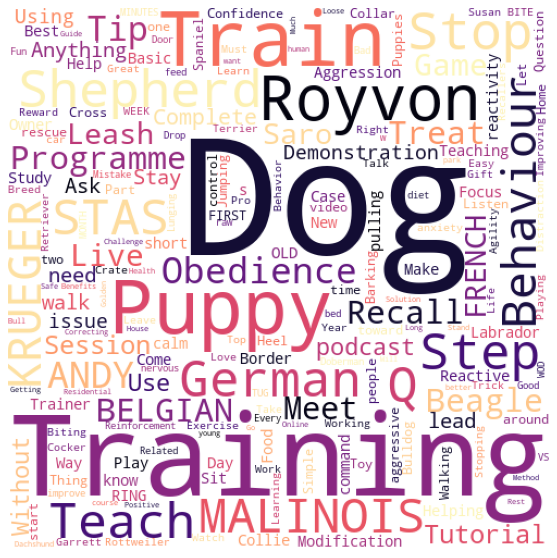

In [73]:
#plot wordcloud and save figure
plot_cloud(medium_wordcloud)
plt.savefig('./Figures/mediumtitlewordcloud.jpg')

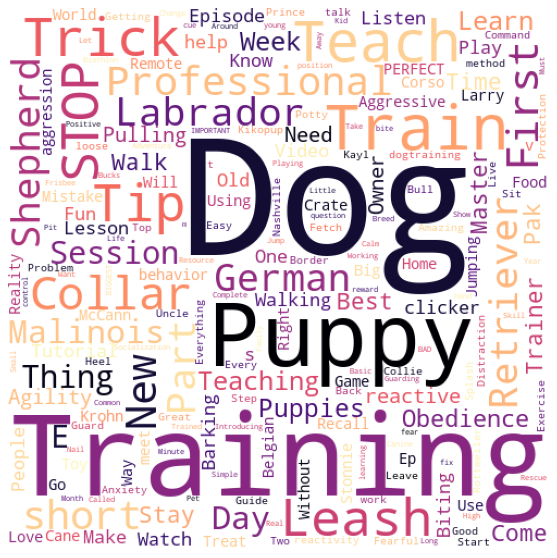

In [74]:
#plot wordcloud and save figure
plot_cloud(high_wordcloud)
plt.savefig('./Figures/hightitlewordcloud.jpg')

# EDA : Comments Datasets

In [75]:
#read comments df
cm_df = pd.read_csv('comments_df.csv')

In [76]:
#merge df with video_df to map video_id and channel titile
cm_df = cm_df.merge(video_df[['video_id','channelTitle','channel_tier']],on='video_id',how='left')

In [77]:
#remove Peter Caine Dog Training channel
cm_df[(cm_df['comments'] != '[]') & (cm_df['channelTitle'] != "Peter Caine Dog Training ")]

video_id                                           comments  \
0     6ZV2Qk7zwME  ['You are both so fast 💨', "Do you have any ti...   
2     sHPVpX-p-ck                          ['Amazing', 'Incredible']   
3     XVCTAUQkdDY  ['I one hundred percent agree with you about h...   
4     ExdMGCn7XOg                                       ['Amazing!']   
5     MTK9BDZTqAY  ['Great Info. Thank you', 'I have a goldendood...   
...           ...                                                ...   
8958  NHSojk4hsr0  ['would be great to see a before video of the ...   
8960  LcY46cjBkAs  ["We have a street dog, Rocky. He's very sweet...   
8962  3WLeyrSMRDg  ['their stunning dogs thanks for sharing this x']   
8968  _mBkn6plhb0  ["You left out :-\n1. They are the worst for p...   
8981  8Nxgtc5vYTo  ['am very interested in applying for a dog, fo...   

                        channelTitle channel_tier  
0                McCann Dogs Agility          low  
2                McCann Dogs Agility          low  
3                McCann Dogs Agility          low  
4                McCann Dogs Agility          low  
5                McCann Dogs Agility          low  
...                              ...          ...  
8958  Royvon Dog Training and Hotels       medium  
8960  Royvon Dog Training and Hotels       medium  
8962  Royvon Dog Training and Hotels       medium  
8968  Royvon Dog Training and Hotels       medium  
8981  Royvon Dog Training and Hotels       medium  

[7479 rows x 4 columns]

In [78]:
#set up empty dataframe
low_comment = pd.DataFrame() 
medium_comment = pd.DataFrame()
high_comment = pd.DataFrame()

#remove stopwords
low_comment['comment_no_stopwords'] = cm_df[cm_df['channel_tier']=='low']['comments'].apply(lambda x : [item for item in x.split() if item not in stop_words])
medium_comment['comment_no_stopwords'] = cm_df[cm_df['channel_tier']=='medium']['comments'].apply(lambda x : [item for item in x.split() if item not in stop_words])
high_comment['comment_no_stopwords'] = cm_df[cm_df['channel_tier']=='high']['comments'].apply(lambda x : [item for item in x.split() if item not in stop_words])

In [79]:
#convert list of list to one list of words
low_comment_words = [a for b in low_comment['comment_no_stopwords'].tolist() for a in b] #I don't get this
medium_comment_words = [a for b in medium_comment['comment_no_stopwords'].tolist() for a in b] #I don't get this
high_comment_words = [a for b in high_comment['comment_no_stopwords'].tolist() for a in b] #I don't get this

In [80]:
#combine list to one giant string
low_comment_words_str = ' '.join(low_comment_words)
medium_comment_words_str = ' '.join(medium_comment_words)
high_comment_words_str = ' '.join(high_comment_words)

In [81]:
#set up wordcloud parameters
low_cm_wordcloud = WordCloud(width=500, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(low_comment_words_str)

medium_cm_wordcloud = WordCloud(width=500, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(medium_comment_words_str)

high_cm_wordcloud = WordCloud(width=500, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(high_comment_words_str)

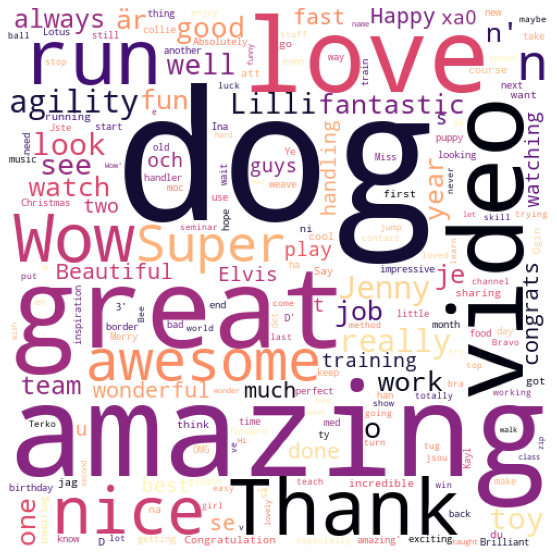

In [82]:
plot_cloud(low_cm_wordcloud)
plt.savefig('./Figures/lowcomments.jpg')

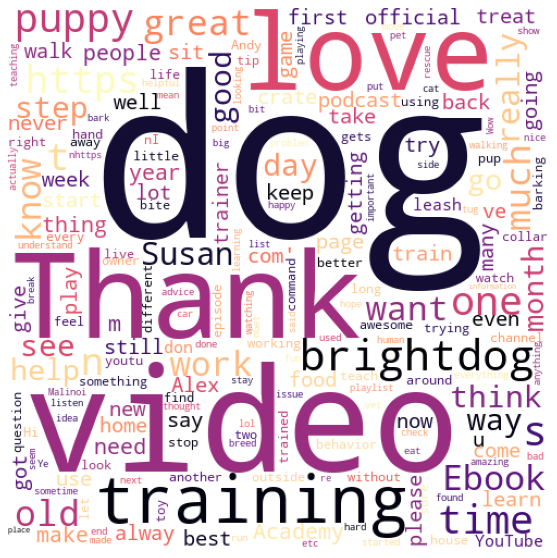

In [83]:
plot_cloud(medium_cm_wordcloud)
plt.savefig('./Figures/mediumcomments.jpg')

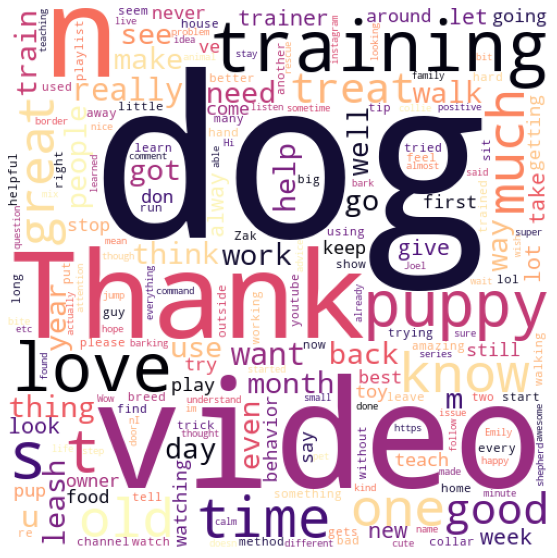

In [84]:
plot_cloud(high_cm_wordcloud)
plt.savefig('./Figures/highcomments.jpg')

# EDA Dig Down : Timeline and progress of selected channel

__Selecting channels to dig down (exclude outliers)__

__High Tier__
- Dog Training by Kikopup
- Will Atherton

__Medium Tier__
- absoluteDogs
- Dogs That

__Low Tier__
- Fenrir Border Collie Show
- Fanny Gott

In [85]:
#High Tier
#selected channels
kikopup = pd.DataFrame(video_df[video_df['channelTitle'] == "Dog Training by Kikopup"])
atherton = pd.DataFrame(video_df[video_df['channelTitle'] == "Will Atherton Canine Training"])
mccan = pd.DataFrame(video_df[video_df['channelTitle'] == "McCann Dog Training"])

#combine high tier channels
selected_high = pd.concat([kikopup,atherton,mccan],ignore_index=True)
selected_high_df = pd.DataFrame(selected_high.groupby(['channelTitle','publishedYear']).count()['video_id'])


#Medium Tier
#selected channels
abs_dogs = pd.DataFrame(video_df[video_df['channelTitle'] == "absoluteDogs"])
dogs_that = pd.DataFrame(video_df[video_df['channelTitle'] == "Dogs That"])
saro = pd.DataFrame(video_df[video_df['channelTitle'] == "Saro Dog Training"])

#combine medium tier channels
selected_medium = pd.concat([abs_dogs,dogs_that,saro],ignore_index=True)
selected_medium_df = pd.DataFrame(selected_medium.groupby(['channelTitle','publishedYear']).count()['video_id'])

#Low Tier
#selected channels
fenrir_bc = pd.DataFrame(video_df[video_df['channelTitle'] == "Fenrir Border Collie Show"])
fanny_gott = pd.DataFrame(video_df[video_df['channelTitle'] == "Fanny Gott"])
omd = pd.DataFrame(video_df[video_df['channelTitle'] == "OneMindDogs"])

#combine low tier channels
selected_low = pd.concat([fenrir_bc,fanny_gott,omd],ignore_index=True)
selected_low_df = pd.DataFrame(selected_low.groupby(['channelTitle','publishedYear']).count()['video_id'])


## Checking age of selected channel

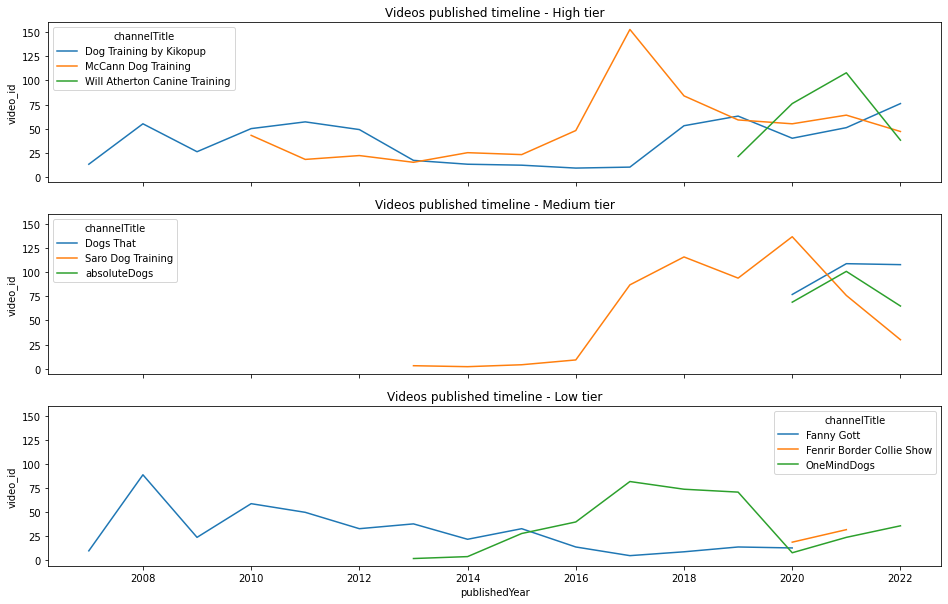

In [86]:
fig, axes = plt.subplots(3, 1,figsize=(16,10),sharey=True,sharex=True)

sns.lineplot(ax=axes[0],x='publishedYear',y='video_id',data=selected_high_df,hue='channelTitle')
axes[0].set_title('Videos published timeline - High tier')

sns.lineplot(ax=axes[1],x='publishedYear',y='video_id',data=selected_medium_df,hue='channelTitle')
axes[1].set_title('Videos published timeline - Medium tier')

sns.lineplot(ax=axes[2],x='publishedYear',y='video_id',data=selected_low_df,hue='channelTitle')
axes[2].set_title('Videos published timeline - Low tier');

## Investigating view distribution of each channels

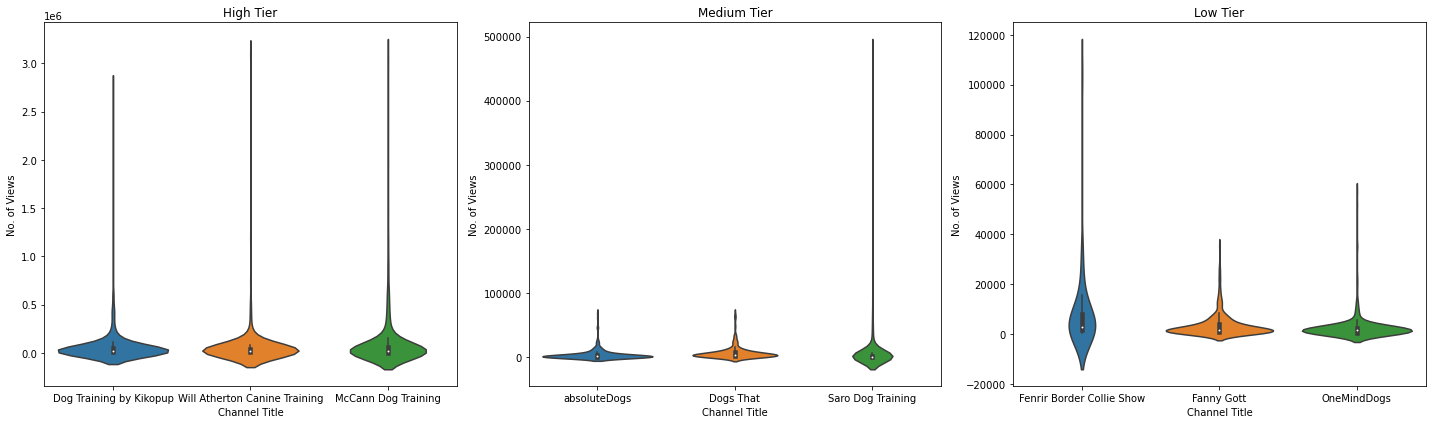

In [87]:
fig, axes = plt.subplots(1, 3,figsize=(20,6))

sns.violinplot(ax=axes[0],x=selected_high['channelTitle'],y=selected_high['viewCount'])
axes[0].set_title('High Tier')
axes[0].set_xlabel('Channel Title')
axes[0].set_ylabel('No. of Views')

sns.violinplot(ax=axes[1],x=selected_medium['channelTitle'],y=selected_medium['viewCount'])
axes[1].set_title('Medium Tier')
axes[1].set_xlabel('Channel Title')
axes[1].set_ylabel('No. of Views')

sns.violinplot(ax=axes[2],x=selected_low['channelTitle'],y=selected_low['viewCount'])
axes[2].set_title('Low Tier')
axes[2].set_xlabel('Channel Title')
axes[2].set_ylabel('No. of Views')

plt.tight_layout()
plt.savefig('./Figures/video_distribution_channel.jpg')

## Investigating those viral videos

Selecting top 3 videos from each channel

In [88]:
#High Tier

kikopup_top3 = kikopup.sort_values(by='viewCount').head(3)
atherton_top3 = atherton.sort_values(by='viewCount').head(3)
mccan_top3 = mccan.sort_values(by='viewCount').head(3)

#concat top 3 df of high tier
top_high = pd.concat([kikopup_top3,atherton_top3,mccan_top3],ignore_index=True)


#Medium Tier
abs_dogs_top3 = abs_dogs.sort_values(by='viewCount').head(3)
dogs_that_top3 = dogs_that.sort_values(by='viewCount').head(3)
saro_top3 = saro.sort_values(by='viewCount').head(3)

#concat top 3 df of medium tier
top_medium = pd.concat([abs_dogs_top3,dogs_that_top3,saro_top3],ignore_index=True)


#Low Tier
fenrir_bc_top3 = fenrir_bc.sort_values(by='viewCount').head(3)
fanny_gott_top3 = fanny_gott.sort_values(by='viewCount').head(3)
omd_top3 = omd.sort_values(by='viewCount').head(3)

#concat top 3 df of low tier
top_low = pd.concat([fenrir_bc_top3,fanny_gott_top3,omd_top3],ignore_index=True)

In [89]:
#set up empty dataframe
top_high_title = pd.DataFrame()
top_medium_title = pd.DataFrame()
top_low_title = pd.DataFrame()

#remove stopwords
top_high_title['title_no_stopwords'] = top_high['title'].apply(lambda x : [item for item in x.split() if item not in stop_words])
top_medium_title['title_no_stopwords'] = top_medium['title'].apply(lambda x : [item for item in x.split() if item not in stop_words])
top_low_title['title_no_stopwords'] = top_low['title'].apply(lambda x : [item for item in x.split() if item not in stop_words])

In [90]:
#convert the list of list to one list of title words
top_high_title_words = [a for b in top_high_title['title_no_stopwords'].tolist() for a in b]
top_medium_title_words = [a for b in top_medium_title['title_no_stopwords'].tolist() for a in b]
top_low_title_words = [a for b in top_low_title['title_no_stopwords'].tolist() for a in b]

In [91]:
#Join list to one string
top_low_title_words_str = ' '.join(low_title_words)
top_medium_title_words_str = ' '.join(medium_title_words)
top_high_title_words_str = ' '.join(high_title_words)

In [92]:
def plot_cloud(wordcloud):
    #function to plot wordcloud with the following settings
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off');
    
top_low_wordcloud = WordCloud(width=500, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(top_low_title_words_str)

top_medium_wordcloud = WordCloud(width=500, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(top_medium_title_words_str)

top_high_wordcloud = WordCloud(width=500, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(top_high_title_words_str)

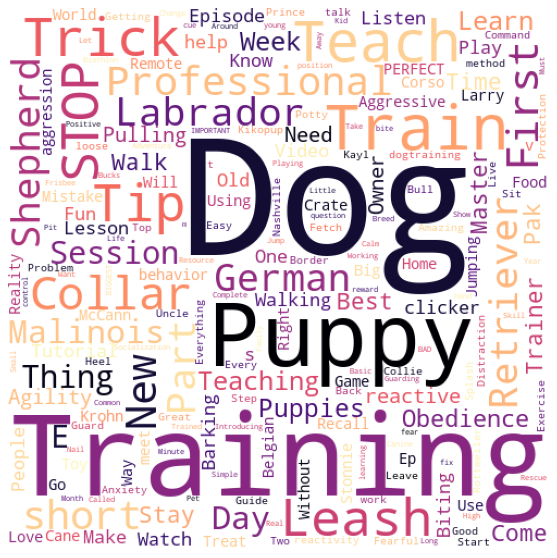

In [93]:
plot_cloud(top_high_wordcloud)

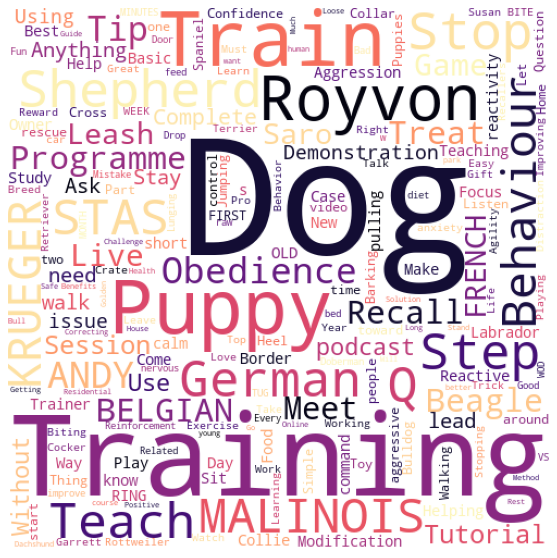

In [94]:
plot_cloud(top_medium_wordcloud)

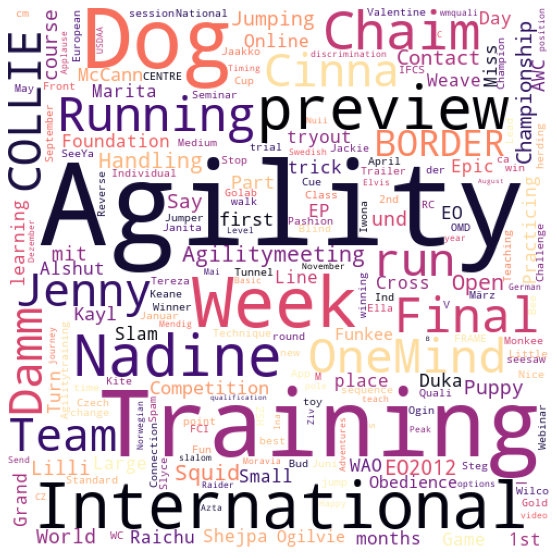

In [95]:
plot_cloud(top_low_wordcloud)

## Investigate tags in selected channels

In [96]:
#set up empty dataframe
top_high_tag = pd.DataFrame()
top_medium_tag = pd.DataFrame()
top_low_tag = pd.DataFrame()

#remove stop words from tag list
top_high_tag['tag_no_stopwords'] = top_high['tags_list'].apply(lambda x : [item for item in x if item not in stop_words])
top_medium_tag['tag_no_stopwords'] = top_medium['tags_list'].apply(lambda x : [item for item in x if item not in stop_words])
top_low_tag['tag_no_stopwords'] = top_low['tags_list'].apply(lambda x : [item for item in x if item not in stop_words])

In [97]:
#combine list of list to one list
top_high_tags_words = [a for b in top_high_tag['tag_no_stopwords'].tolist() for a in b] 
top_medium_tags_words = [a for b in top_medium_tag['tag_no_stopwords'].tolist() for a in b]
top_low_tags_words = [a for b in top_low_tag['tag_no_stopwords'].tolist() for a in b] 

In [98]:
#join to giant string
top_high_tags_words_str = ' '.join(top_high_tags_words)
top_medium_tags_words_str = ' '.join(top_medium_tags_words)
top_low_tags_words_str = ' '.join(top_low_tags_words)

In [99]:
top_high_tags_wordcloud = WordCloud(width=500, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(top_high_tags_words_str)

top_medium_tags_wordcloud = WordCloud(width=500, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(top_medium_tags_words_str)

top_low_tags_wordcloud = WordCloud(width=500, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(top_low_tags_words_str)

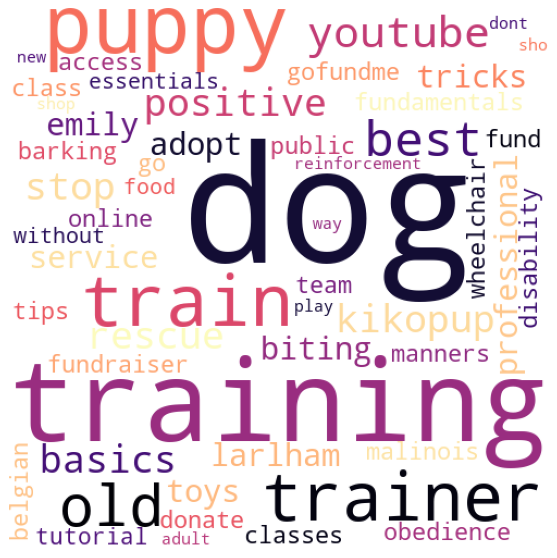

In [100]:
plot_cloud(top_high_tags_wordcloud)

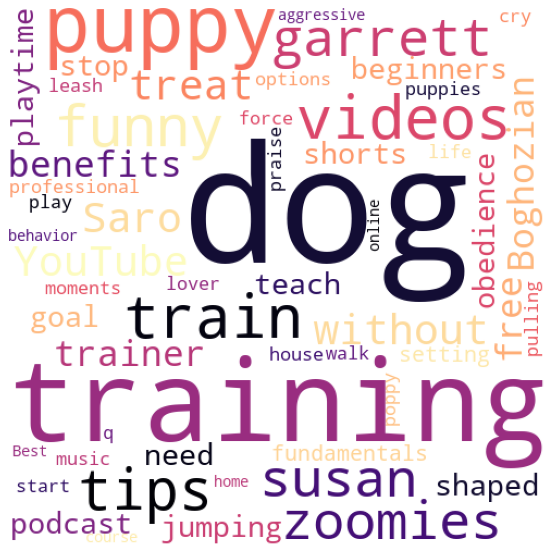

In [101]:
plot_cloud(top_medium_tags_wordcloud)

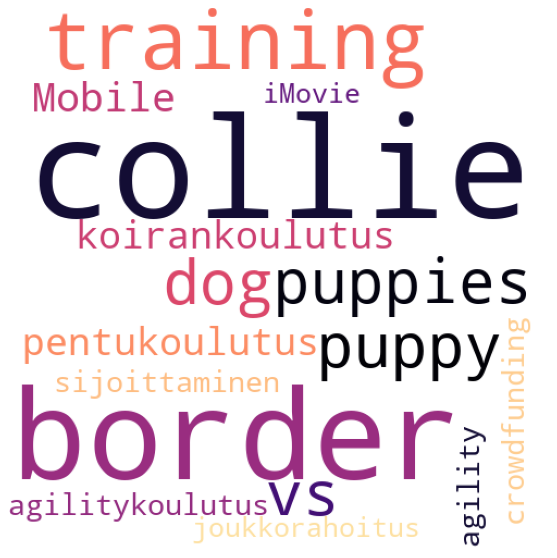

In [102]:
plot_cloud(top_low_tags_wordcloud)

## Investigating whether titles are set by focusing on stopwords like "how to", "what is"

In [103]:
#create empty dataframe
top_high_title = pd.DataFrame()
top_medium_title = pd.DataFrame()
top_low_title = pd.DataFrame()

#split title without removing stopwords
top_high_title['title'] = top_high['title'].apply(lambda x : [item for item in x.split()])
top_medium_title['title'] = top_medium['title'].apply(lambda x : [item for item in x.split()])
top_low_title['title'] = top_low['title'].apply(lambda x : [item for item in x.split()])

In [104]:
#combine list
top_high_title_words = [a for b in top_high_title['title'].tolist() for a in b] #I don't get this
top_medium_title_words = [a for b in top_medium_title['title'].tolist() for a in b] #I don't get this
top_low_title_words = [a for b in top_low_title['title'].tolist() for a in b] #I don't get this

In [105]:
#join to string
top_low_title_words_str = ' '.join(top_low_title_words)
top_medium_title_words_str = ' '.join(medium_title_words)
top_high_title_words_str = ' '.join(top_high_title_words)

In [106]:
top_high_title_wordcloud = WordCloud(width=500, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(top_high_title_words_str)

top_medium_title_wordcloud = WordCloud(width=500, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(top_medium_title_words_str)

top_low_title_wordcloud = WordCloud(width=500, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(top_low_title_words_str)

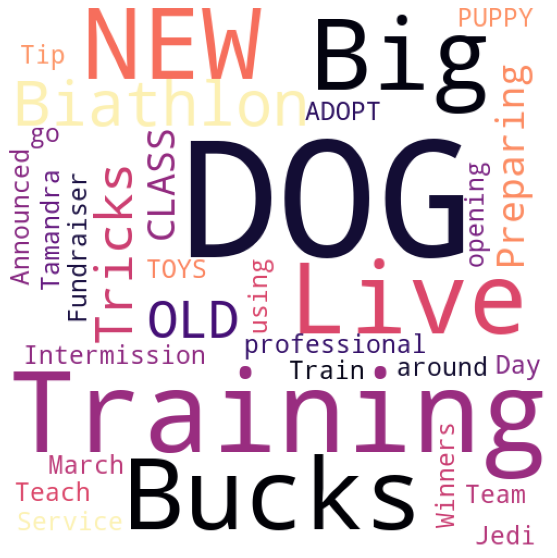

In [107]:
plot_cloud(top_high_title_wordcloud)

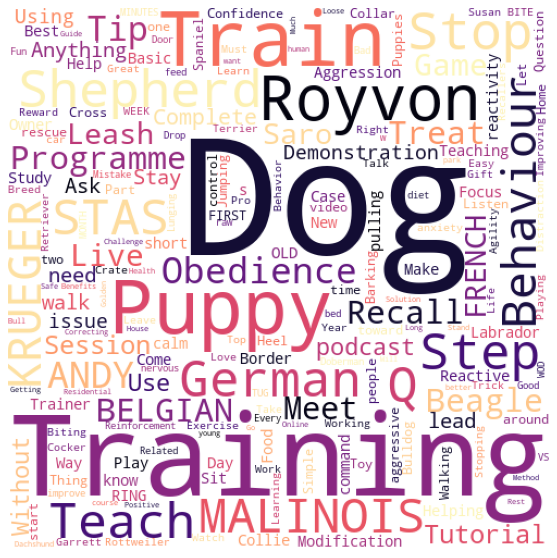

In [108]:
plot_cloud(top_medium_title_wordcloud)

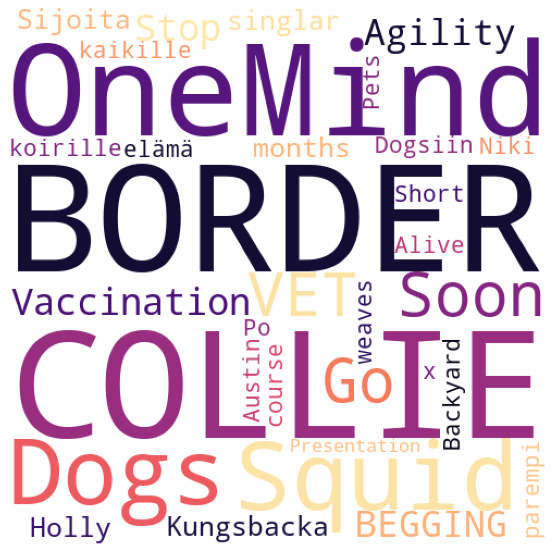

In [109]:
plot_cloud(top_low_title_wordcloud)

## Investigate title setting tricks by checking the top videos from top youtube channels

In [110]:
#High Tier - select top 10 videos sort by views from top 2 channels

kikopup_top10 = kikopup.sort_values(by='viewCount',ascending=False).head(10)
zak = pd.DataFrame(video_df[video_df['channelTitle'] == "Zak George’s Dog Training Revolution"])
zak_top10 = zak.sort_values(by='viewCount',ascending=False).head(10)


In [111]:
#set up empty dataframe
kiko_title = pd.DataFrame()
zak_title = pd.DataFrame()

#split title words without removing stopwords
kiko_title['title'] = kikopup_top10['title'].apply(lambda x : [item for item in x.split()])
zak_title['title'] = zak_top10['title'].apply(lambda x : [item for item in x.split()])

In [112]:
#combine to one list
kiko_title_words = [a for b in kiko_title['title'].tolist() for a in b] 
zak_title_words = [a for b in zak_title['title'].tolist() for a in b]

In [113]:
#join to string
kiko_title_words_str = ' '.join(kiko_title_words)
zak_title_words = ' '.join(zak_title_words)

In [114]:
kiko_title_wordcloud = WordCloud(width=500, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(kiko_title_words_str)

zak_title_wordcloud = WordCloud(width=500, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(zak_title_words)

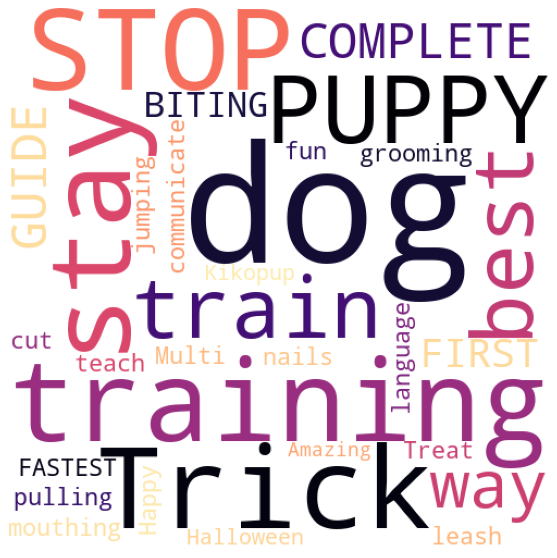

In [115]:
plot_cloud(kiko_title_wordcloud)
plt.savefig('./Figures/kikotitle.jpg')

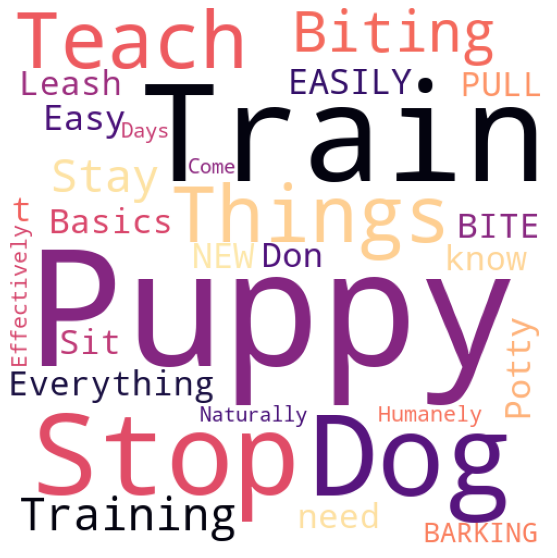

In [116]:
plot_cloud(zak_title_wordcloud)
plt.savefig('./Figures/zak.jpg')

Convert to dataframe and save as excel file for future use with ppt

In [117]:
kiko_top10 = pd.DataFrame(kikopup_top10[['title','viewCount']])

In [118]:
zak_top10 = pd.DataFrame(zak_top10[['title','viewCount']])

In [119]:
kiko_top10.to_excel("kiko_top10.xlsx")
zak_top10.to_excel("zak_top10.xlsx")